In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from ipywidgets import interactive
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' %x)

## Reading CSVs
~ ecs_updated (becomes ecs) - includes funding details for all 50 states + DC (needs to be merged on State)

~ enrollment_changes (becomes enrollments) - includes calculations for annual enrollment changes by NCES ID (filtered to local districts not affiliated with a supervisory union only and only includes columns needed for the loop or for merging, can be merged on State with ECS data or on NCES ID for other sources)

~ localdistricts (becomes localdistricts) - does not include enrollment change calculations, but does still include columns for locale, ZIP code, FTE count, pupil/teacher ratio, and year (can be merged on NCES ID or State depending on the need, shape aligns exactly to enrollment_changes)

~ enrollmentsdf (becomes fullnces) - primary dataframe until the loop; contains all columns and rows so it may ultimately prove to need more cleaning and restructuring than is helpful (can be merged by state or NCES ID)

In [ ]:
ecs = pd.read_csv("../data/ecs_updated.csv")
ecs.head(3)

In [ ]:
enrollments = pd.read_csv("../data/enrollment_changes.csv")
enrollments.head(3)

In [ ]:
localdistricts = pd.read_csv("../data/localdistricts.csv")
localdistricts.head(3)

In [ ]:
#unlikely to use, but here for reference as needed
fullnces = pd.read_csv("../data/enrollmentsdf.csv")
fullnces.head(3)

In [ ]:
netchangedist = enrollments.groupby(['State Name', 'Agency Name', 'NCES ID'])['Enrollment Change'].sum().reset_index()
netchangedist.head()

## Cleaning & Standardizing DataFrames

In [ ]:
ecs = ecs.drop("Unnamed: 0", axis=1)
ecs.head(2)

In [ ]:
ecs.rename(columns={'State':'State Name'}, inplace=True)
ecs.head(1)

In [ ]:
enrollments = enrollments.drop("Unnamed: 0", axis=1)
enrollments.head(2)

In [ ]:
netchangedist.rename(columns={'Enrollment Change':'Net Enrollment Change'}, inplace=True)
netchangedist.head(2)

## Merging DataFrames
Will also include dropping duplicate/unnecessary columns, standardizing column names, and reordering columns for efficiency.

In [ ]:
netenrollments = enrollments.merge(netchangedist, on='NCES ID', suffixes=('_nces', '_net'))
netenrollments.head(3)

In [ ]:
netenrollments.rename(columns={'Agency Name_nces':'Agency Name', 'State Name_nces':'State Name', 'Enrollment Change_nces':'Annual Enrollment Change', 'Enrollment Change_net':'Net Enrollment Change'}, inplace=True)
netenrollments.head(3)

In [ ]:
netenrollments = netenrollments.drop(['State Name_net', 'Agency Name_net'], axis=1)
netenrollments.head(3)

In [ ]:
enrollments.shape

In [ ]:
netchangedist.shape

In [ ]:
netenrollments.shape

In [ ]:
localdistricts.shape

In [ ]:
netandlocal = localdistricts.merge(netenrollments, on=['NCES ID', 'Year'], how='left', suffixes=('_loc', '_net'))
netandlocal.shape
#dataframes were the same shape - needed left merge rather than outer to avoid 8x duplicates

In [ ]:
netandlocal.head(3)

In [ ]:
netandlocal = netandlocal.drop(['Student Count_loc', 'Agency Name', 'District', 'State me'], axis=1)
netandlocal.head(3)

In [ ]:
netandlocal.rename(columns={'Agency me':'Agency Name', 'State me':'State Name', 'Student Count_net':'Student Count'}, inplace=True)
netandlocal.head(3)

In [ ]:
netandlocal.shape

In [ ]:
netfunding = netandlocal.merge(ecs, on='State Name', how='outer', suffixes=('_net', '_ecs'))
netfunding.shape

In [ ]:
netfunding.info()
#all rows should have a state name given the df shape and non-null count

In [ ]:
netfunding.head(2)

In [ ]:
#netfunding.to_csv("../data/netfunding.csv")

In [ ]:
#netandlocal.to_csv("../data/netandlocal2.csv")

In [ ]:
#netenrollments.to_csv("../data/netenrollments.csv")

## Additional DataFrames & Cleaning

In [ ]:
data = pd.read_csv("../data/netfunding.csv")
data.shape

In [ ]:
data.info()

In [ ]:
data.head(2)

In [ ]:
#data = data.drop(['Unnamed: 0'], axis=1)
#data.head(1)

In [ ]:
cols = list(data.columns.values)
cols

In [ ]:
cols = ['Agency Name', 'State Name', 'State Abbreviation', 'NCES ID', 'County', 'Student Count', 'Year', 'Enrollment Change', 'Net Enrollment Change', 'School Count', 'ZIP Code', 'District Type', 'Locale', 'Start of Year Status', 'Updated Status', 'FTE Teachers', 'Pupil/Teacher Ratio', 'Total Staff', 'Census Region', '2020 Election Result', '2020 Battleground State', 'Primary Funding Model', 'Model Name', 'Notes', 'Base Amount (Y/N)', 'Base Amount', 'Base Amount Legal Source', 'Student Count Method', 'Student Count Method Source']

In [ ]:
data = data[cols]
data.head(2)

In [ ]:
data['NCES ID'] = data['NCES ID'].astype(str).str.replace('.0', '', regex=False)
data.head(2)

In [ ]:
data['Year'] = data['Year'].astype(str).str.replace('.0', '', regex=False)
data.head(2)

In [ ]:
data['ZIP Code'] = data['ZIP Code'].astype(str).str.replace('.0', '', regex=False)
data.head(2)

In [ ]:
data['Net Enrollment Change'] = data['Net Enrollment Change'].astype(str).str.replace('.0', '', regex=False)
data.head(2)

In [ ]:
data['Net Enrollment Change'] = pd.to_numeric(data['Net Enrollment Change'], errors='coerce')
data['Net Enrollment Change'].dtype

In [ ]:
data['School Count'] = data['School Count'].astype(str).str.replace('.0', '', regex=False)
data.head(2)

In [ ]:
data['School Count'] = pd.to_numeric(data['School Count'], errors='coerce')
data['School Count'].dtype

In [ ]:
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
data['Year'].dtype

In [ ]:
data['ZIP Code'] = pd.to_numeric(data['ZIP Code'], errors='coerce')
data['ZIP Code'].dtype

In [ ]:
data.info()

In [ ]:
data.to_csv("../data/capstonedata_2.csv")
#dtypes have been changed and extra columns removed

## Import Final CSV & EDA

In [2]:
data = pd.read_csv("../data/capstonedata_final.csv", nrows=104923)
data.tail()

C:\Users\cbrown\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (24,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source
104918,104918,WASHAKIE COUNTY SCHOOL DISTRICT #1,WYOMING,WY,5606240.00,Washakie County,1274.00,2017.00,-55.00,-239.00,5.00,82401.00,1.00,33-Town: Remote,1-Open,1-Open,108.00,12.00,251.00,West,Republican,No,Resource-based allocation,Education resource block grant model,NaN,No,NaN,NaN,Membership average,Wyo. Stat. Ann. § 21-13-101(a)(i) Wyo. Stat. A...
104919,104919,WASHAKIE COUNTY SCHOOL DISTRICT #1,WYOMING,WY,5606240.00,Washakie County,1272.00,2018.00,-2.00,-239.00,5.00,82401.00,1.00,33-Town: Remote,1-Open,1-Open,104.00,12.00,242.00,West,Republican,No,Resource-based allocation,Education resource block grant model,NaN,No,NaN,NaN,Membership average,Wyo. Stat. Ann. § 21-13-101(a)(i) Wyo. Stat. A...
104920,104920,WASHAKIE COUNTY SCHOOL DISTRICT #1,WYOMING,WY,5606240.00,Washakie County,1244.00,2019.00,-28.00,-239.00,5.00,82401.00,1.00,33-Town: Remote,1-Open,1-Open,104.00,12.00,235.00,West,Republican,No,Resource-based allocation,Education resource block grant model,NaN,No,NaN,NaN,Membership average,Wyo. Stat. Ann. § 21-13-101(a)(i) Wyo. Stat. A...
104921,104921,WASHAKIE COUNTY SCHOOL DISTRICT #1,WYOMING,WY,5606240.00,Washakie County,1147.00,2020.00,-97.00,-239.00,5.00,82401.00,1.00,33-Town: Remote,1-Open,1-Open,100.00,11.00,230.00,West,Republican,No,Resource-based allocation,Education resource block grant model,NaN,No,NaN,NaN,Membership average,Wyo. Stat. Ann. § 21-13-101(a)(i) Wyo. Stat. A...
104922,104922,NaN,VERMONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northeast,Democrat,No,Guaranteed tax base,NaN,NaN,No,NaN,NaN,Membership average,"Vt. Stat. Ann. tit. 16, § 4010"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104923 entries, 0 to 104922
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   104923 non-null  int64  
 1   Agency Name                  104922 non-null  object 
 2   State Name                   104923 non-null  object 
 3   State Abbreviation           104922 non-null  object 
 4   NCES ID                      104922 non-null  float64
 5   County                       104898 non-null  object 
 6   Student Count                103984 non-null  float64
 7   Year                         104922 non-null  float64
 8   Enrollment Change            90612 non-null   float64
 9   Net Enrollment Change        104922 non-null  float64
 10  School Count                 104922 non-null  float64
 11  ZIP Code                     104922 non-null  float64
 12  District Type                104922 non-null  float64
 13 

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head(1)

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source
0,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002.00,MONTGOMERY COUNTY,NaN,2013.00,NaN,0.00,7.00,36057.00,1.00,21-Suburb: Large,1-Open,NaN,0.00,NaN,0.00,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232


In [5]:
data['NCES ID'] = pd.to_numeric(data['NCES ID'], errors='coerce')
data['NCES ID'].dtype

dtype('float64')

In [6]:
data['ZIP Code'] = pd.to_numeric(data['ZIP Code'], errors='coerce')
data['ZIP Code'].dtype

dtype('float64')

In [7]:
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
data['Year'].dtype

dtype('float64')

In [8]:
data['Annual Budgetary Change'] = data['Enrollment Change'] * data['Base Amount']

In [9]:
data['Net Budgetary Change'] = data['Net Enrollment Change'] * data['Base Amount']

In [12]:
data.head()

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Annual Budgetary Change,Net Budgetary Change
0,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002.00,MONTGOMERY COUNTY,NaN,2013.00,NaN,0.00,7.00,36057.00,1.00,21-Suburb: Large,1-Open,NaN,0.00,NaN,0.00,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,NaN,NaN
1,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002.00,JEFFERSON COUNTY,NaN,2014.00,NaN,0.00,6.00,36057.00,1.00,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,NaN,NaN
2,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002.00,Jefferson County,NaN,2015.00,NaN,0.00,6.00,36057.00,1.00,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,NaN,NaN
3,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002.00,Jefferson County,NaN,2016.00,NaN,0.00,6.00,36057.00,1.00,41-Rural: Fringe,1-Open,1-Open,0.00,NaN,NaN,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,NaN,NaN
4,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002.00,Jefferson County,NaN,2018.00,NaN,0.00,0.00,36057.00,1.00,21-Suburb: Large,1-Open,1-Open,0.00,NaN,0.00,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,NaN,NaN


In [10]:
data['Annual Budgetary Change'].value_counts()

0.00              844
-8485.75          121
-16971.50         116
-36960.00         111
-33943.00         110
16971.50          110
-6160.00          105
6160.00           105
25457.25          104
18480.00          104
-24640.00         102
12320.00          101
-30800.00         101
-49280.00          98
-55440.00          96
-25457.25          96
-67886.00          95
8485.75            95
30800.00           94
-18480.00          91
-59400.25          91
6375.00            90
42428.75           88
36960.00           88
-80080.00          88
33943.00           87
-61600.00          87
-43120.00          86
24640.00           86
50914.50           84
49280.00           83
-73920.00          83
61600.00           80
43120.00           79
-12320.00          77
67760.00           77
20505.00           75
-67760.00          75
-82020.00          74
-13670.00          73
-6835.00           72
-102525.00         72
-42428.75          72
-93343.25          72
80080.00           71
-47845.00 

In [11]:
data['Net Budgetary Change'].value_counts()

0.00              1213
-25457.25           88
8485.75             76
-73920.00           72
-6160.00            72
-92400.00           72
12320.00            64
-86240.00           64
36960.00            64
-80080.00           64
-172480.00          64
-104720.00          64
-33943.00           64
-50914.50           63
33943.00            56
-498955.00          56
-12750.00           56
-63750.00           56
197120.00           56
-153000.00          56
-114750.00          56
-184875.00          56
6160.00             56
-12320.00           56
110880.00           56
-205050.00          56
-82875.00           56
-16971.50           56
-242250.00          56
44625.00            56
-95625.00           56
-258720.00          56
144257.75           55
-34175.00           50
63750.00            48
-464780.00          48
-369600.00          48
-462000.00          48
43120.00            48
86240.00            48
-25500.00           48
-234080.00          48
-203658.00          48
-751850.00 

In [13]:
sbfdn = data.loc[data['Primary Funding Model'] == 'Student-based foundation']

In [14]:
rbased = data.loc[data['Primary Funding Model'] == 'Resource-based allocation']

In [15]:
hybrid = data.loc[data['Primary Funding Model'] == 'Hybrid']

In [16]:
gtbase = data.loc[data['Primary Funding Model'] == 'Guaranteed tax base']

In [17]:
baseamt = data.loc[data['Base Amount (Y/N)'] == 'Yes']

In [18]:
nbaseamt = data.loc[data['Base Amount (Y/N)'] == 'No']

In [19]:
northeast = data.loc[data['Census Region'] == 'Northeast']

In [20]:
midwest = data.loc[data['Census Region'] == 'Midwest']

In [21]:
south = data.loc[data['Census Region'] == 'South']

In [22]:
west = data.loc[data['Census Region'] == 'West']

In [23]:
republican = data.loc[data['2020 Election Result'] == 'Republican']

In [24]:
democrat = data.loc[data['2020 Election Result'] == 'Democrat']

In [25]:
batlgrnd = data.loc[data['2020 Battleground State'] == 'Yes']

In [26]:
nbatlgrnd = data.loc[data['2020 Battleground State'] == 'No']

In [27]:
year13 = data.loc[data['Year'] == 2013]
year13.head()

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Annual Budgetary Change,Net Budgetary Change
0,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002.00,MONTGOMERY COUNTY,NaN,2013.00,NaN,0.00,7.00,36057.00,1.00,21-Suburb: Large,1-Open,NaN,0.00,NaN,0.00,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,NaN,NaN
7,ALBERTVILLE CITY,ALABAMA,AL,100005.00,MARSHALL COUNTY,4713.00,2013.00,NaN,1129.00,6.00,35950.00,1.00,32-Town: Distant,1-Open,NaN,260.00,18.00,369.00,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,NaN,NaN
15,MARSHALL COUNTY,ALABAMA,AL,100006.00,MARSHALL COUNTY,5604.00,2013.00,NaN,154.00,16.00,35976.00,1.00,42-Rural: Distant,1-Open,NaN,359.00,16.00,496.00,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,NaN,NaN
23,HOOVER CITY,ALABAMA,AL,100007.00,JEFFERSON COUNTY,13943.00,2013.00,NaN,-303.00,17.00,35243.00,1.00,13-City: Small,1-Open,NaN,938.00,15.00,1269.00,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,NaN,NaN
31,MADISON CITY,ALABAMA,AL,100008.00,MADISON COUNTY,9554.00,2013.00,NaN,2250.00,11.00,35758.00,1.00,21-Suburb: Large,1-Open,NaN,529.00,18.00,1013.00,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,NaN,NaN


In [28]:
year14 = data.loc[data['Year'] == 2014]

In [29]:
year15 = data.loc[data['Year'] == 2015]

In [30]:
year16 = data.loc[data['Year'] == 2016]

In [31]:
year17 = data.loc[data['Year'] == 2017]

In [32]:
year18 = data.loc[data['Year'] == 2018]

In [33]:
year19 = data.loc[data['Year'] == 2019]

In [34]:
year20 = data.loc[data['Year'] == 2020]

In [35]:
top25g1 = data.nlargest(200, "Net Enrollment Change", keep='last')
top25g1
#running with 200 because variable numbers within each row keep them from being seen as duplicates. Next step is drop the unneeded columns, then drop dupes, and then rename the df for usability

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Annual Budgetary Change,Net Budgetary Change
91439,FRISCO ISD,TEXAS,TX,4820010.00,Collin County,63493.00,2020.00,788.00,17440.00,74.00,75035.00,1.00,21-Suburb: Large,1-Open,1-Open,4389.00,14.00,7620.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,4854080.00,107430400.00
91438,FRISCO ISD,TEXAS,TX,4820010.00,Collin County,62705.00,2019.00,2523.00,17440.00,73.00,75035.00,1.00,21-Suburb: Large,1-Open,1-Open,4279.00,15.00,7400.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,15541680.00,107430400.00
91437,FRISCO ISD,TEXAS,TX,4820010.00,Collin County,60182.00,2018.00,1732.00,17440.00,73.00,75035.00,1.00,21-Suburb: Large,1-Open,1-Open,4071.00,15.00,7048.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,10669120.00,107430400.00
91436,FRISCO ISD,TEXAS,TX,4820010.00,Collin County,58450.00,2017.00,2527.00,17440.00,69.00,75035.00,1.00,21-Suburb: Large,1-Open,1-Open,3822.00,15.00,6581.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,15566320.00,107430400.00
91435,FRISCO ISD,TEXAS,TX,4820010.00,Collin County,55923.00,2016.00,2623.00,17440.00,69.00,75035.00,1.00,21-Suburb: Large,1-Open,1-Open,3814.00,15.00,6647.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,16157680.00,107430400.00
91434,FRISCO ISD,TEXAS,TX,4820010.00,Collin County,53300.00,2015.00,3656.00,17440.00,64.00,75035.00,1.00,21-Suburb: Large,1-Open,1-Open,3519.00,15.00,6231.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,22520960.00,107430400.00
91433,FRISCO ISD,TEXAS,TX,4820010.00,COLLIN COUNTY,49644.00,2014.00,3591.00,17440.00,62.00,75035.00,1.00,21-Suburb: Large,1-Open,1-Open,3290.00,15.00,5915.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,22120560.00,107430400.00
91432,FRISCO ISD,TEXAS,TX,4820010.00,COLLIN COUNTY,46053.00,2013.00,NaN,17440.00,55.00,75035.00,1.00,21-Suburb: Large,1-Open,NaN,3052.00,15.00,5410.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,NaN,107430400.00
92590,KATY ISD,TEXAS,TX,4825170.00,Fort Bend County,84176.00,2020.00,753.00,16963.00,73.00,77494.00,1.00,21-Suburb: Large,1-Open,1-Open,5882.00,14.00,11553.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,4638480.00,104492080.00
92589,KATY ISD,TEXAS,TX,4825170.00,Fort Bend County,83423.00,2019.00,3510.00,16963.00,72.00,77494.00,1.00,21-Suburb: Large,1-Open,1-Open,5603.00,15.00,11024.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,21621600.00,104492080.00


In [36]:
top25g = top25g1.drop_duplicates(subset=['Net Enrollment Change'], keep='last')
top25g

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Annual Budgetary Change,Net Budgetary Change
91432,FRISCO ISD,TEXAS,TX,4820010.00,COLLIN COUNTY,46053.00,2013.00,NaN,17440.00,55.00,75035.00,1.00,21-Suburb: Large,1-Open,NaN,3052.00,15.00,5410.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,NaN,107430400.00
92583,KATY ISD,TEXAS,TX,4825170.00,FORT BEND COUNTY,67213.00,2013.00,NaN,16963.00,61.00,77494.00,1.00,21-Suburb: Large,1-Open,NaN,4303.00,16.00,8163.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,NaN,104492080.00
16489,HILLSBOROUGH,FLORIDA,FL,1200870.00,HILLSBOROUGH COUNTY,203439.00,2013.00,NaN,15504.00,310.00,33602.00,1.00,21-Suburb: Large,1-Open,NaN,14266.00,14.00,26640.00,South,Republican,Yes,Student-based foundation,Florida Education Finance Program,NaN,Yes,4571.15,Fla. Stat. Ann. § 1011.62 S.B. 2500,Membership average,Fla. Stat. Ann. § 1011.62,NaN,70871109.60
94764,PROSPER ISD,TEXAS,TX,4836000.00,COLLIN COUNTY,6413.00,2013.00,NaN,12725.00,7.00,75078.00,1.00,41-Rural: Fringe,1-Open,NaN,421.00,15.00,743.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,NaN,78386000.00
16641,ORANGE,FLORIDA,FL,1201440.00,ORANGE COUNTY,187092.00,2013.00,NaN,11997.00,249.00,32801.00,1.00,21-Suburb: Large,1-Open,NaN,11760.00,16.00,22944.00,South,Republican,Yes,Student-based foundation,Florida Education Finance Program,NaN,Yes,4571.15,Fla. Stat. Ann. § 1011.62 S.B. 2500,Membership average,Fla. Stat. Ann. § 1011.62,NaN,54840086.55
16721,ST. JOHNS,FLORIDA,FL,1201740.00,ST. JOHNS COUNTY,33583.00,2013.00,NaN,10967.00,48.00,32084.00,1.00,21-Suburb: Large,1-Open,NaN,2420.00,14.00,4454.00,South,Republican,Yes,Student-based foundation,Florida Education Finance Program,NaN,Yes,4571.15,Fla. Stat. Ann. § 1011.62 S.B. 2500,Membership average,Fla. Stat. Ann. § 1011.62,NaN,50131802.05
91912,HALLSVILLE ISD,TEXAS,TX,4822170.00,HARRISON COUNTY,4760.00,2013.00,NaN,10507.00,7.00,75650.00,1.00,31-Town: Fringe,1-Open,NaN,338.00,14.00,624.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,NaN,64723120.00
17361,FORSYTH COUNTY,GEORGIA,GA,1302220.00,FORSYTH COUNTY,40691.00,2013.00,NaN,10461.00,36.00,30040.00,1.00,21-Suburb: Large,1-Open,NaN,2375.00,17.00,4296.00,South,Democrat,Yes,Hybrid,Quality Basic Education,NaN,Yes,2775.21,HB793 (Budget bill),Multiple counts,Ga. Code Ann. § 20-2-160,NaN,29031471.81
16649,OSCEOLA,FLORIDA,FL,1201470.00,OSCEOLA COUNTY,58204.00,2013.00,NaN,10436.00,69.00,34744.00,1.00,21-Suburb: Large,1-Open,NaN,3517.00,17.00,7093.00,South,Republican,Yes,Student-based foundation,Florida Education Finance Program,NaN,Yes,4571.15,Fla. Stat. Ann. § 1011.62 S.B. 2500,Membership average,Fla. Stat. Ann. § 1011.62,NaN,47704521.40
97823,LOUDOUN CO PBLC SCHS,VIRGINIA,VA,5102250.00,LOUDOUN COUNTY,70759.00,2013.00,NaN,10307.00,85.00,20148.00,1.00,21-Suburb: Large,1-Open,NaN,5026.00,14.00,10784.00,South,Democrat,No,Resource-based allocation,Standards of Quality Formula,NaN,No,NaN,NaN,Membership average,Va. Code Ann. § 22.1-70.1 Va. Code Ann. § 22.1...,NaN,NaN


In [37]:
len(top25g)

25

In [38]:
top25l1 = data.nsmallest(200, "Net Enrollment Change", keep='last')
len(top25l1)

200

In [39]:
top25l = top25l1.drop_duplicates(subset=['Net Enrollment Change'], keep='last')
top25l

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Annual Budgetary Change,Net Budgetary Change
9445,LOS ANGELES UNIFIED,CALIFORNIA,CA,622710.00,LOS ANGELES COUNTY,653826.00,2013.00,NaN,-193193.00,983.00,90017.00,1.00,11-City: Large,1-Open,NaN,27748.00,24.00,62858.00,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,NaN,-1639387499.75
20787,CITY OF CHICAGO SD 299,ILLINOIS,IL,1709930.00,COOK COUNTY,396641.00,2013.00,NaN,-55259.00,595.00,60603.00,1.00,11-City: Large,1-Open,NaN,23320.00,17.00,45545.00,Midwest,Democrat,No,Hybrid,Evidence-Based Funding,NaN,No,NaN,NaN,Multiple counts,105 Ill. Comp. Stat. Ann. 5/18-8.15,NaN,NaN
87662,SHELBY COUNTY,TENNESSEE,TN,4700148.00,SHELBY COUNTY,149832.00,2013.00,NaN,-39052.00,290.00,38112.00,1.00,11-City: Large,3-New,NaN,9282.00,16.00,14167.00,South,Republican,No,Resource-based allocation,Basic Education Program,NaN,No,NaN,NaN,Membership average,Tenn. Code Ann. § 49-3-302 Tenn. Code Ann. § 4...,NaN,NaN
11372,SAN DIEGO UNIFIED,CALIFORNIA,CA,634320.00,SAN DIEGO COUNTY,130303.00,2013.00,NaN,-32335.00,225.00,92103.00,1.00,11-City: Large,1-Open,NaN,5461.00,24.00,11803.00,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,NaN,-274386726.25
16361,MIAMI-DADE,FLORIDA,FL,1200390.00,MIAMI-DADE COUNTY,356233.00,2013.00,NaN,-21972.00,534.00,33132.00,1.00,21-Suburb: Large,1-Open,NaN,20527.00,17.00,34218.00,South,Republican,Yes,Student-based foundation,Florida Education Finance Program,NaN,Yes,4571.15,Fla. Stat. Ann. § 1011.62 S.B. 2500,Membership average,Fla. Stat. Ann. § 1011.62,NaN,-100437307.80
92231,HOUSTON ISD,TEXAS,TX,4823640.00,HARRIS COUNTY,211552.00,2013.00,NaN,-14609.00,283.00,77092.00,1.00,11-City: Large,1-Open,NaN,11336.00,19.00,23114.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,NaN,-89991440.00
90680,DALLAS ISD,TEXAS,TX,4816230.00,DALLAS COUNTY,159713.00,2013.00,NaN,-14600.00,234.00,75204.00,1.00,11-City: Large,1-Open,NaN,9830.00,16.00,16778.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,NaN,-89936000.00
84133,PHILADELPHIA CITY SD,PENNSYLVANIA,PA,4218990.00,PHILADELPHIA COUNTY,137674.00,2013.00,NaN,-13563.00,214.00,19130.00,1.00,11-City: Large,1-Open,NaN,7646.00,18.00,14909.00,Northeast,Democrat,Yes,Student-based foundation,Reimbursements by Commonwealth and Between Sch...,NaN,No,NaN,NaN,Membership average,24 Pa. Stat. Ann. § 25-2501,NaN,NaN
11564,SANTA A UNIFIED,CALIFORNIA,CA,635310.00,ORANGE COUNTY,57499.00,2013.00,NaN,-13228.00,60.00,92701.00,1.00,11-City: Large,1-Open,NaN,2145.00,27.00,4059.00,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,NaN,-112249501.00
9413,LONG BEACH UNIFIED,CALIFORNIA,CA,622500.00,LOS ANGELES COUNTY,81155.00,2013.00,NaN,-11742.00,86.00,90810.00,1.00,11-City: Large,1-Open,NaN,2967.00,27.00,6975.00,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,NaN,-99639676.50


In [40]:
len(top25l)

25

## EDA

In [41]:
#looking for areas of strong correlation to dig into with deeper analysis
# fig, ax = plt.subplots(figsize=(10, 10))

# corr = data.corr()
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# sns.heatmap(corr, cmap=cmap, mask = mask, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [42]:
top25g['Locale'].value_counts(normalize=True)*100

21-Suburb: Large   72.00
13-City: Small      8.00
41-Rural: Fringe    4.00
31-Town: Fringe     4.00
32-Town: Distant    4.00
43-Rural: Remote    4.00
11-City: Large      4.00
Name: Locale, dtype: float64

In [43]:
top25g['State Name'].value_counts(normalize=True)*100

TEXAS            36.00
FLORIDA          24.00
UTAH             12.00
GEORGIA           8.00
MARYLAND          8.00
VIRGINIA          4.00
IDAHO             4.00
NORTH CAROLINA    4.00
Name: State Name, dtype: float64

In [44]:
top25g['Primary Funding Model'].value_counts(normalize=True)*100

Student-based foundation    80.00
Resource-based allocation   12.00
Hybrid                       8.00
Name: Primary Funding Model, dtype: float64

In [45]:
top25g['2020 Election Result'].value_counts(normalize=True)*100

Republican   80.00
Democrat     20.00
Name: 2020 Election Result, dtype: float64

In [46]:
top25g['Census Region'].value_counts(normalize=True)*100

South   84.00
West    16.00
Name: Census Region, dtype: float64

In [47]:
top25g.groupby('Agency Name')['School Count'].value_counts()

Agency Name                            School Count
ALPINE DISTRICT                        81.00           1
ALVIN ISD                              23.00           1
CONROE ISD                             55.00           1
FORSYTH COUNTY                         36.00           1
FRISCO ISD                             55.00           1
GWINNETT COUNTY                        132.00          1
HALLSVILLE ISD                         7.00            1
HILLSBOROUGH                           310.00          1
HUMBLE ISD                             43.00           1
KATY ISD                               61.00           1
LAMAR CISD                             37.00           1
LEE                                    120.00          1
LOUDOUN CO PBLC SCHS                   85.00           1
MONTGOMERY COUNTY PUBLIC SCHOOLS       207.00          1
NORTHWEST ISD                          26.00           1
ONEIDA COUNTY DISTRICT                 5.00            1
ORANGE                              

In [48]:
top25l['Locale'].value_counts(normalize=True)*100

11-City: Large      76.00
21-Suburb: Large    16.00
12-City: Mid-size    8.00
Name: Locale, dtype: float64

In [49]:
top25l['State Name'].value_counts(normalize=True)*100

TEXAS          32.00
CALIFORNIA     28.00
ILLINOIS        4.00
TENNESSEE       4.00
FLORIDA         4.00
PENNSYLVANIA    4.00
HAWAII          4.00
NEW MEXICO      4.00
OKLAHOMA        4.00
LOUISIANA       4.00
MISSISSIPPI     4.00
INDIANA         4.00
Name: State Name, dtype: float64

In [50]:
top25l['Primary Funding Model'].value_counts(normalize=True)*100

Student-based foundation    88.00
Hybrid                       8.00
Resource-based allocation    4.00
Name: Primary Funding Model, dtype: float64

In [51]:
top25l['2020 Election Result'].value_counts(normalize=True)*100

Republican   56.00
Democrat     44.00
Name: 2020 Election Result, dtype: float64

In [52]:
top25l['Census Region'].value_counts(normalize=True)*100

South       52.00
West        36.00
Midwest      8.00
Northeast    4.00
Name: Census Region, dtype: float64

In [53]:
top25l.groupby('Agency Name')['School Count'].value_counts()

Agency Name                     School Count
ALBUQUERQUE PUBLIC SCHOOLS      162.00          1
ARLINGTON ISD                   77.00           1
AUSTIN ISD                      128.00          1
BROWNSVILLE ISD                 60.00           1
CAPISTRANO UNIFIED              63.00           1
CITY OF CHICAGO SD 299          595.00          1
DALLAS ISD                      234.00          1
EL PASO ISD                     95.00           1
FORT WORTH ISD                  144.00          1
HAWAII DEPARTMENT OF EDUCATION  288.00          1
HOUSTON ISD                     283.00          1
INDIAPOLIS PUBLIC SCHOOLS       68.00           1
JACKSON PUBLIC SCHOOL DISTRICT  63.00           1
LONG BEACH UNIFIED              86.00           1
LOS ANGELES UNIFIED             983.00          1
MIAMI-DADE                      534.00          1
OAKLAND UNIFIED                 123.00          1
OKLAHOMA CITY                   80.00           1
ORLEANS PARISH                  21.00           1
PHILA

In [54]:
data['Locale'].value_counts(normalize=True)*100

42-Rural: Distant     22.48
21-Suburb: Large      19.13
43-Rural: Remote      17.75
41-Rural: Fringe      12.16
32-Town: Distant       8.44
33-Town: Remote        5.82
31-Town: Fringe        3.95
13-City: Small         3.08
22-Suburb: Mid-size    2.47
23-Suburb: Small       1.75
11-City: Large         1.55
12-City: Mid-size      1.42
Name: Locale, dtype: float64

In [55]:
data['State Name'].value_counts(normalize=True)*100

TEXAS                  7.82
CALIFORNIA             7.71
ILLINOIS               6.58
NEW YORK               5.29
OHIO                   4.72
NEW JERSEY             4.41
MICHIGAN               4.15
MISSOURI               3.96
OKLAHOMA               3.92
PENNSYLVANIA           3.81
WISCONSIN              3.21
MONTANA                3.10
IOWA                   2.56
MINNESOTA              2.54
KANSAS                 2.29
WASHINGTON             2.28
INDIANA                2.24
MASSACHUSETTS          2.23
MAINE                  1.91
NEBRASKA               1.87
ARKANSAS               1.79
ARIZONA                1.75
GEORGIA                1.37
NORTH DAKOTA           1.36
OREGON                 1.36
COLORADO               1.36
KENTUCKY               1.32
CONNECTICUT            1.29
SOUTH DAKOTA           1.14
TENNESSEE              1.11
MISSISSIPPI            1.11
ALABAMA                1.04
VIRGINIA               1.00
NORTH CAROLINA         0.90
IDAHO                  0.88
NEW MEXICO          

In [56]:
data['Primary Funding Model'].value_counts(normalize=True)*100

Student-based foundation    74.30
Hybrid                      13.20
Resource-based allocation    9.29
Guaranteed tax base          3.22
Name: Primary Funding Model, dtype: float64

In [57]:
data['2020 Election Result'].value_counts(normalize=True)*100

Democrat     53.69
Republican   46.31
Name: 2020 Election Result, dtype: float64

In [58]:
data['Census Region'].value_counts(normalize=True)*100

Midwest     36.62
South       23.83
West        20.34
Northeast   19.21
Name: Census Region, dtype: float64

In [59]:
growth_desc = top25g.describe()
growth_desc
#keep in mind that topenrollmentgrowth is based on 2013

,NCES ID,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Base Amount,Annual Budgetary Change,Net Budgetary Change
count,25.00,25.00,25.00,0.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,22.00,0.00,22.00
mean,3325427.20,69969.80,2013.00,NaN,9834.76,88.80,55056.56,1.00,4471.56,16.56,8617.32,5256.11,NaN,53245697.67
std,1718468.59,60322.82,0.00,NaN,3108.67,81.59,25710.72,0.00,4024.11,2.74,7748.87,1452.22,NaN,22894736.06
min,1200870.00,923.00,2013.00,NaN,6268.00,5.00,20148.00,1.00,47.00,13.00,72.00,2775.21,NaN,22898257.71
25%,1302220.00,27079.00,2013.00,NaN,7293.00,36.00,32084.00,1.00,1255.00,15.00,2514.00,4571.15,NaN,35626395.47
50%,4808090.00,55009.00,2013.00,NaN,9269.00,55.00,75035.00,1.00,3078.00,16.00,5741.00,5365.57,NaN,48918161.72
75%,4826580.00,87425.00,2013.00,NaN,10507.00,120.00,77471.00,1.00,5517.00,17.00,11072.00,6160.00,NaN,63255500.00
max,5102250.00,203439.00,2013.00,NaN,17440.00,310.00,84770.00,1.00,14266.00,24.00,26640.00,7991.00,NaN,107430400.00


In [60]:
loss_desc = top25l.describe()
loss_desc
#keep in mind that topenrollmentloss is based on 2013

,NCES ID,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Base Amount,Annual Budgetary Change,Net Budgetary Change
count,25.00,25.00,25.00,0.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,20.00,0.00,20.00
mean,2823652.72,131106.92,2013.00,NaN,-22059.16,202.08,73273.80,1.00,7096.00,18.64,13919.44,6699.61,NaN,-159662609.84
std,1826199.33,144778.13,0.00,NaN,37390.41,216.61,21791.67,0.00,7102.21,4.66,14473.86,1466.92,NaN,351958201.42
min,607440.00,12447.00,2013.00,NaN,-193193.00,21.00,19130.00,1.00,804.00,12.00,1563.00,4015.00,NaN,-1639387499.75
25%,635310.00,49370.00,2013.00,NaN,-14600.00,77.00,70114.00,1.00,2415.00,16.00,4306.00,6118.75,NaN,-99404196.94
50%,2802190.00,81155.00,2013.00,NaN,-10501.00,123.00,78210.00,1.00,4121.00,17.00,8172.00,6160.00,NaN,-75406023.88
75%,4808940.00,149832.00,2013.00,NaN,-9178.00,234.00,90810.00,1.00,9282.00,22.00,14909.00,8485.75,NaN,-50580307.80
max,4838730.00,653826.00,2013.00,NaN,-7730.00,983.00,96813.00,1.00,27748.00,29.00,62858.00,8485.75,NaN,-36849670.00


In [61]:
desc_13 = year13.describe()
desc_13

,NCES ID,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Base Amount,Annual Budgetary Change,Net Budgetary Change
count,13072.00,12955.00,13072.00,0.00,13072.00,13072.00,13072.00,13072.00,12977.00,12821.00,13008.00,7706.00,0.00,7706.00
mean,2955926.67,3612.67,2013.00,NaN,-140.77,6.84,53952.54,1.00,222.35,14.53,433.58,7062.02,NaN,-1213981.52
std,1469689.67,12381.75,0.00,NaN,2039.44,18.05,27473.83,0.00,701.68,5.64,1360.83,2193.13,NaN,20285944.58
min,100002.00,0.00,2013.00,NaN,-193193.00,0.00,1002.00,1.00,0.00,0.00,0.00,2489.00,NaN,-1639387499.75
25%,1803172.50,418.00,2013.00,NaN,-173.00,2.00,36693.50,1.00,33.00,12.00,60.00,6160.00,NaN,-1168473.00
50%,3005865.00,1149.00,2013.00,NaN,-44.00,3.00,58321.00,1.00,78.00,14.00,151.50,6567.00,NaN,-276900.00
75%,4024847.50,3058.00,2013.00,NaN,10.00,6.00,74868.00,1.00,193.00,17.00,378.00,8485.75,NaN,98913.84
max,5606240.00,653826.00,2013.00,NaN,17440.00,983.00,99929.00,1.00,27748.00,417.00,62858.00,13436.20,NaN,107430400.00


In [62]:
desc_14 = year14.describe()
desc_14

,NCES ID,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Base Amount,Annual Budgetary Change,Net Budgetary Change
count,13191.00,12968.00,13191.00,12861.00,13191.00,13191.00,13191.00,13191.00,11128.00,10979.00,11910.00,7812.00,7548.00,7812.00
mean,2935087.96,3629.26,2014.00,12.07,-140.96,6.80,54287.26,1.00,240.86,14.71,459.36,7079.47,164799.91,-1223209.17
std,1480153.77,12388.27,0.00,418.92,2032.17,18.01,27662.87,0.00,747.01,4.42,1419.81,2188.51,3365013.20,20168228.35
min,100002.00,0.00,2014.00,-34022.00,-193193.00,0.00,1002.00,1.00,0.00,0.00,0.00,2489.00,-123861225.00,-1639387499.75
25%,1743005.00,417.00,2014.00,-24.00,-173.00,2.00,37036.50,1.00,35.00,12.00,61.00,6160.00,-154000.00,-1169914.50
50%,3002030.00,1145.00,2014.00,-1.00,-44.00,3.00,58554.00,1.00,85.00,14.00,159.00,6567.00,4305.73,-274132.50
75%,4022995.00,3069.25,2014.00,22.00,10.00,6.00,75153.00,1.00,209.00,17.00,407.00,8485.75,203354.25,95047.09
max,5606240.00,646683.00,2014.00,5460.00,17440.00,999.00,99929.00,1.00,27669.00,122.00,67000.00,13436.20,64291500.00,107430400.00


In [63]:
desc_15 = year15.describe()
desc_15

,NCES ID,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Base Amount,Annual Budgetary Change,Net Budgetary Change
count,13163.00,12966.00,13163.00,12924.00,13163.00,13163.00,13163.00,13163.00,12905.00,12770.00,12923.00,7788.00,7608.00,7788.00
mean,2936612.64,3632.84,2015.00,1.54,-141.05,6.81,54259.48,1.00,224.36,14.61,455.58,7082.41,3308.38,-1223778.86
std,1480755.92,12401.20,0.00,269.72,2034.55,18.06,27666.21,0.00,708.78,15.50,1389.14,2192.47,3174795.47,20201947.49
min,100002.00,0.00,2015.00,-7346.00,-193193.00,0.00,1002.00,1.00,0.00,0.00,0.00,2489.00,-62336319.50,-1639387499.75
25%,1742870.00,422.00,2015.00,-29.00,-174.00,2.00,36862.50,1.00,33.00,12.00,64.00,6160.00,-201353.96,-1177002.00
50%,3002250.00,1139.00,2015.00,-4.00,-44.00,3.00,58540.00,1.00,78.00,14.00,164.00,6567.00,-25500.00,-280235.00
75%,4023355.00,3045.00,2015.00,16.00,10.00,6.00,75148.50,1.00,193.00,17.00,407.00,8485.75,119406.00,98560.00
max,5606240.00,639337.00,2015.00,9926.00,17440.00,1009.00,99929.00,1.00,27493.00,1700.00,68484.00,13436.20,116878650.00,107430400.00


In [64]:
desc_16 = year16.describe()
desc_16

,NCES ID,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Base Amount,Annual Budgetary Change,Net Budgetary Change
count,13144.00,13019.00,13144.00,12908.00,13144.00,13144.00,13144.00,13144.00,13048.00,12875.00,12990.00,7709.00,7584.00,7709.00
mean,2934476.01,3631.77,2016.00,5.28,-141.71,6.81,53996.32,1.00,223.52,14.95,461.16,7058.94,38751.31,-1233927.51
std,1477888.76,12374.83,0.00,196.42,2035.89,18.07,27874.58,0.00,708.80,59.53,1408.39,2171.91,1443350.78,20303462.63
min,100002.00,0.00,2016.00,-9112.00,-193193.00,0.00,1002.00,1.00,0.00,0.00,0.00,2489.00,-48504547.00,-1639387499.75
25%,1800099.00,424.00,2016.00,-24.00,-176.00,2.00,36055.00,1.00,33.00,12.00,65.00,6160.00,-170580.00,-1192212.00
50%,2931590.00,1141.00,2016.00,-2.00,-45.00,3.00,58414.50,1.00,78.00,14.00,167.00,6567.00,-13707.00,-287280.00
75%,4023047.50,3042.50,2016.00,18.00,11.00,6.00,75135.50,1.00,192.00,17.00,410.00,8485.75,136557.50,102525.00
max,5606240.00,633621.00,2016.00,3723.00,17440.00,1012.00,99929.00,1.00,28088.00,6752.00,69989.00,13436.20,21562290.75,107430400.00


In [65]:
desc_17 = year17.describe()
desc_17

,NCES ID,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Base Amount,Annual Budgetary Change,Net Budgetary Change
count,13147.00,13033.00,13147.00,13004.00,13147.00,13147.00,13147.00,13147.00,13054.00,12877.00,12993.00,7704.00,7599.00,7704.00
mean,2935825.19,3626.30,2017.00,-3.71,-141.50,6.81,53940.90,1.00,223.33,14.36,462.95,7060.31,-7462.12,-1234331.73
std,1477781.12,12317.74,0.00,244.81,2035.74,18.24,27872.73,0.00,704.21,4.20,1399.85,2172.18,2035676.72,20310111.84
min,100005.00,0.00,2017.00,-12207.00,-193193.00,0.00,1002.00,1.00,0.00,0.00,0.00,2489.00,-103585550.25,-1639387499.75
25%,1800138.50,420.00,2017.00,-29.00,-176.00,2.00,35963.50,1.00,33.00,12.00,65.00,6160.00,-188400.00,-1194060.00
50%,2931800.00,1141.00,2017.00,-4.00,-45.00,3.00,58356.00,1.00,78.00,14.00,167.00,6567.00,-20505.00,-288181.25
75%,4023130.00,3041.00,2017.00,17.00,11.00,6.00,75112.00,1.00,193.00,16.00,411.00,8485.75,135646.00,104180.00
max,5606240.00,621414.00,2017.00,5166.00,17440.00,1009.00,99929.00,1.00,27377.00,99.00,67476.00,13436.20,44060814.00,107430400.00


In [66]:
desc_18 = year18.describe()
desc_18

,NCES ID,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Base Amount,Annual Budgetary Change,Net Budgetary Change
count,13106.00,13033.00,13106.00,12969.00,13106.00,13106.00,13106.00,13106.00,13061.00,12928.00,13063.00,7623.00,7550.00,7623.00
mean,2942958.54,3581.87,2018.00,-42.05,-141.97,6.77,53754.29,1.00,223.15,14.33,462.08,7056.03,-590362.67,-1248378.21
std,1473589.69,11794.32,0.00,1189.81,2038.91,17.23,27802.79,0.00,676.79,9.97,1360.29,2176.61,13077793.58,20417271.67
min,100002.00,0.00,2018.00,-126159.00,-193193.00,0.00,1002.00,1.00,0.00,0.00,0.00,2489.00,-1070553734.25,-1639387499.75
25%,1800285.00,410.00,2018.00,-31.00,-176.75,2.00,35654.75,1.00,33.00,12.00,64.00,6160.00,-244000.00,-1211184.00
50%,3000003.50,1127.00,2018.00,-4.00,-46.00,3.00,58264.00,1.00,79.00,14.00,168.00,6567.00,-34145.50,-299625.00
75%,4023722.50,2995.00,2018.00,14.00,11.00,6.00,74947.75,1.00,193.00,16.00,411.00,8485.75,108378.15,110878.50
max,5606240.00,495255.00,2018.00,4409.00,17440.00,785.00,99929.00,1.00,21981.00,1047.00,55923.00,13436.20,27159440.00,107430400.00


In [67]:
desc_19 = year19.describe()
desc_19

,NCES ID,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Base Amount,Annual Budgetary Change,Net Budgetary Change
count,13057.00,13025.00,13057.00,12974.00,13057.00,13057.00,13057.00,13057.00,13023.00,11934.00,12024.00,7617.00,7545.00,7617.00
mean,2946780.61,3585.67,2019.00,1.04,-141.82,6.77,53738.71,1.00,206.98,13.71,459.55,7056.86,-529.15,-1242463.37
std,1474011.39,11756.64,0.00,227.94,2042.92,17.27,27832.43,0.00,652.63,8.35,1309.06,2175.88,1763897.65,20426569.77
min,100002.00,0.00,2019.00,-12021.00,-193193.00,0.00,1002.00,1.00,0.00,0.00,0.00,2489.00,-102007200.75,-1639387499.75
25%,1801560.00,412.00,2019.00,-24.00,-177.00,2.00,35611.00,1.00,25.00,11.00,67.00,6160.00,-170875.00,-1210125.00
50%,3000933.00,1121.00,2019.00,-2.00,-46.00,3.00,58102.00,1.00,70.00,14.00,169.00,6567.00,-13707.00,-297095.37
75%,4024510.00,2970.00,2019.00,17.00,11.00,6.00,74956.00,1.00,175.00,16.00,405.25,8485.75,123030.00,110880.00
max,5606240.00,483234.00,2019.00,3510.00,17440.00,785.00,99929.00,1.00,21943.00,831.00,36640.00,13436.20,26330345.00,107430400.00


In [68]:
desc_20 = year20.describe()
desc_20

,NCES ID,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Base Amount,Annual Budgetary Change,Net Budgetary Change
count,13042.00,12985.00,13042.00,12972.00,13042.00,13042.00,13042.00,13042.00,12099.00,11997.00,12105.00,7602.00,7549.00,7602.00
mean,2946739.67,3478.48,2020.00,-117.28,-141.94,6.77,53738.03,1.00,228.96,14.08,476.06,7056.07,-868229.01,-1244757.96
std,1474534.45,11352.52,0.00,492.16,2044.08,17.25,27837.74,0.00,669.70,19.13,1397.38,2176.13,3763793.33,20446578.40
min,100002.00,0.00,2020.00,-22601.00,-193193.00,0.00,1002.00,1.00,0.00,0.00,0.00,2489.00,-191786435.75,-1639387499.75
25%,1801417.50,402.00,2020.00,-100.00,-177.00,2.00,35615.75,1.00,33.00,11.00,66.00,6160.00,-724510.00,-1211118.00
50%,3000932.50,1093.00,2020.00,-33.00,-46.00,3.00,58221.00,1.00,80.00,14.00,170.00,6567.00,-229115.25,-297110.06
75%,4024810.00,2885.00,2020.00,-5.00,11.00,6.00,74956.75,1.00,198.00,16.00,420.00,8485.75,-39402.00,110880.00
max,5606240.00,460633.00,2020.00,4442.00,17440.00,782.00,99929.00,1.00,21873.00,1738.00,57324.00,13436.20,23957200.00,107430400.00


In [69]:
budgetloss = data.nsmallest(25, "Annual Budgetary Change", keep='last')
budgetloss

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Annual Budgetary Change,Net Budgetary Change
9450,LOS ANGELES UNIFIED,CALIFORNIA,CA,622710.00,Los Angeles County,495255.00,2018.00,-126159.00,-193193.00,785.00,90017.00,1.00,11-City: Large,1-Open,1-Open,21981.00,23.00,55923.00,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,-1070553734.25,-1639387499.75
11377,SAN DIEGO UNIFIED,CALIFORNIA,CA,634320.00,San Diego County,103194.00,2018.00,-23206.00,-32335.00,176.00,92103.00,1.00,11-City: Large,1-Open,1-Open,4388.00,24.00,10427.00,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,-196920314.50,-274386726.25
9452,LOS ANGELES UNIFIED,CALIFORNIA,CA,622710.00,Los Angeles County,460633.00,2020.00,-22601.00,-193193.00,782.00,90017.00,1.00,11-City: Large,1-Open,1-Open,21873.00,21.00,57324.00,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,-191786435.75,-1639387499.75
59013,FREEHOLD REGIOL HIGH SCHOOL DISTRICT,NEW JERSEY,NJ,3405610.00,MONMOUTH COUNTY,901.00,2014.00,-10519.00,-901.00,6.00,7726.00,1.00,21-Suburb: Large,1-Open,1-Open,771.00,1.00,1623.00,Northeast,Democrat,No,Student-based foundation,School Funding Reform Act,The base per pupil amount and students weights...,Yes,11775.00,N.J. Stat. Ann. § 18A:7F-46 N.J. Stat. Ann. § ...,Single count,N.J. Stat. Ann. § 18A:7F-45,-123861225.00,-10609275.00
5243,ACTON-AGUA DULCE UNIFIED,CALIFORNIA,CA,600001.00,Los Angeles County,1085.00,2018.00,-13770.00,-1464.00,3.00,93510.00,1.00,41-Rural: Fringe,1-Open,1-Open,49.00,22.00,131.00,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,-116848777.50,-12423138.00
10356,OAKLAND UNIFIED,CALIFORNIA,CA,628050.00,Alameda County,36524.00,2018.00,-13707.00,-11705.00,91.00,94607.00,1.00,11-City: Large,1-Open,1-Open,1912.00,19.00,4274.00,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,-116314175.25,-99325703.75
9449,LOS ANGELES UNIFIED,CALIFORNIA,CA,622710.00,Los Angeles County,621414.00,2017.00,-12207.00,-193193.00,1009.00,90017.00,1.00,11-City: Large,1-Open,1-Open,27377.00,23.00,67476.00,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,-103585550.25,-1639387499.75
9451,LOS ANGELES UNIFIED,CALIFORNIA,CA,622710.00,Los Angeles County,483234.00,2019.00,-12021.00,-193193.00,785.00,90017.00,1.00,11-City: Large,1-Open,1-Open,0.00,NaN,NaN,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,-102007200.75,-1639387499.75
57549,CLARK COUNTY SCHOOL DISTRICT,NEVADA,NV,3200060.00,Clark County,315646.00,2020.00,-13345.00,-4886.00,374.00,89146.00,1.00,11-City: Large,1-Open,1-Open,14395.00,22.00,30124.00,West,Democrat,Yes,Student-based foundation,Pupil Centered Funding Plan,NaN,Yes,6980.00,Nev. Rev. Stat. Ann. § 387.1214 SB458 (Budget ...,Membership average,Nev. Rev. Stat. Ann. § 387.123,-93148100.00,-34104280.00
11425,SAN JUAN UNIFIED,CALIFORNIA,CA,634620.00,Sacramento County,40058.00,2018.00,-9986.00,-9817.00,68.00,95608.00,1.00,21-Suburb: Large,1-Open,1-Open,1691.00,24.00,3805.00,West,Democrat,No,Student-based foundation,Local Control

In [70]:
budgetloss['Annual Budgetary Change'].value_counts()

-1070553734.25    1
-65891848.75      1
-49616180.25      1
-51466073.75      1
-52357077.50      1
-53887680.00      1
-54453057.75      1
-58076473.00      1
-59635222.90      1
-59739680.00      1
-60613712.25      1
-62336319.50      1
-72459819.25      1
-196920314.50     1
-79233975.00      1
-80806880.00      1
-84738699.50      1
-93148100.00      1
-102007200.75     1
-103585550.25     1
-116314175.25     1
-116848777.50     1
-123861225.00     1
-191786435.75     1
-48504547.00      1
Name: Annual Budgetary Change, dtype: int64

In [71]:
budgetgrowth = data.nlargest(25, "Annual Budgetary Change", keep='last')
budgetgrowth

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Annual Budgetary Change,Net Budgetary Change
59014,FREEHOLD REGIOL HIGH SCHOOL DISTRICT,NEW JERSEY,NJ,3405610.00,Monmouth County,10827.00,2015.00,9926.00,-901.00,6.00,7726.00,1.00,21-Suburb: Large,1-Open,1-Open,771.00,14.00,1625.00,Northeast,Democrat,No,Student-based foundation,School Funding Reform Act,The base per pupil amount and students weights...,Yes,11775.00,N.J. Stat. Ann. § 18A:7F-46 N.J. Stat. Ann. § ...,Single count,N.J. Stat. Ann. § 18A:7F-45,116878650.00,-10609275.00
59748,LEPE REGIOL HIGH SCHOOL DISTRICT,NEW JERSEY,NJ,3408490.00,Burlington County,6887.00,2015.00,6640.00,-85.00,4.00,8088.00,1.00,21-Suburb: Large,1-Open,1-Open,584.00,12.00,1365.00,Northeast,Democrat,No,Student-based foundation,School Funding Reform Act,The base per pupil amount and students weights...,Yes,11775.00,N.J. Stat. Ann. § 18A:7F-46 N.J. Stat. Ann. § ...,Single count,N.J. Stat. Ann. § 18A:7F-45,78186000.00,-1000875.00
60472,NEWARK PUBLIC SCHOOL DISTRICT,NEW JERSEY,NJ,3411340.00,Essex County,40889.00,2015.00,6028.00,5447.00,65.00,7102.00,1.00,11-City: Large,1-Open,1-Open,2733.00,15.00,5518.00,Northeast,Democrat,No,Student-based foundation,School Funding Reform Act,The base per pupil amount and students weights...,Yes,11775.00,N.J. Stat. Ann. § 18A:7F-46 N.J. Stat. Ann. § ...,Single count,N.J. Stat. Ann. § 18A:7F-45,70979700.00,64138425.00
60816,PATERSON PUBLIC SCHOOL DISTRICT,NEW JERSEY,NJ,3412690.00,PASSAIC COUNTY,30058.00,2014.00,5460.00,1339.00,47.00,7503.00,1.00,21-Suburb: Large,1-Open,1-Open,2212.00,14.00,4367.00,Northeast,Democrat,No,Student-based foundation,School Funding Reform Act,The base per pupil amount and students weights...,Yes,11775.00,N.J. Stat. Ann. § 18A:7F-46 N.J. Stat. Ann. § ...,Single count,N.J. Stat. Ann. § 18A:7F-45,64291500.00,15766725.00
58051,BLACK HORSE PIKE REGIOL SCHOOL DISTRICT,NEW JERSEY,NJ,3401770.00,Camden County,4022.00,2015.00,3992.00,-310.00,3.00,8012.00,1.00,21-Suburb: Large,1-Open,1-Open,277.00,15.00,531.00,Northeast,Democrat,No,Student-based foundation,School Funding Reform Act,The base per pupil amount and students weights...,Yes,11775.00,N.J. Stat. Ann. § 18A:7F-46 N.J. Stat. Ann. § ...,Single count,N.J. Stat. Ann. § 18A:7F-45,47005800.00,-3650250.00
40101,DETROIT PUBLIC SCHOOLS COMMUNITY DISTRICT,MICHIGAN,MI,2601103.00,Wayne County,50621.00,2017.00,5166.00,3327.00,110.00,48202.00,1.00,11-City: Large,1-Open,1-Open,2927.00,17.00,6091.00,Midwest,Democrat,Yes,Student-based foundation,Foundation Grant,NaN,Yes,8529.00,Mich. Comp. Laws Ann. § 388.1620,Multiple counts,Mich. Comp. Laws Ann. § 388.1606,44060814.00,28375983.00
61657,TRENTON PUBLIC SCHOOLS,NEW JERSEY,NJ,3416290.00,MERCER COUNTY,13881.00,2014.00,3493.00,4320.00,22.00,8609.00,1.00,13-City: Small,1-Open,1-Open,1006.00,14.00,2008.00,Northeast,Democrat,No,Student-based foundation,School Funding Reform Act,The base per pupil amount and students weights...,Yes,11775.00,N.J. Stat. Ann. § 18A:7F-46 N.J. Stat. Ann. § ...,Single count,N.J. Stat. Ann. § 18A:7F-45,41130075.00,50868000.00
5242,ACTON-AGUA DULCE UNIFIED,CALIFORNIA,CA,600001.00,Los Angeles County,14855.00,2017.00,4839.00,-1464.00,20.00,93510.00,1.00,42-Rural: Distant,1-Open,1-Open,641.00,23.00,1240.00,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,8485.75,CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,41062544.25,-12423138.00
59569,JERSEY CITY PUBLIC SCHOOLS,NEW JERSEY,NJ,3407830.00,HUDSON COUNTY,30845.00,2014.00,3274.00,-789.00,38.00,7305.00,1.00,12-City: Mid-size,1-Open,1-Open,2389.00,13.00,4465.00,Northeast,Democ

In [72]:
budgetgrowth['Annual Budgetary Change'].value_counts()

30956475.00     2
116878650.00    1
78186000.00     1
28942950.00     1
29096025.00     1
29123094.00     1
29237325.00     1
29304352.20     1
29402175.00     1
30308850.00     1
32133975.00     1
33429225.00     1
34335900.00     1
35831325.00     1
35949075.00     1
37727100.00     1
38551350.00     1
41062544.25     1
41130075.00     1
44060814.00     1
47005800.00     1
64291500.00     1
70979700.00     1
28766325.00     1
Name: Annual Budgetary Change, dtype: int64

## to_csv

In [73]:
#data.to_csv("../data/capstonedata_final.csv")

In [74]:
#data.to_csv("../data/top25_growth.csv")

In [75]:
#data.to_csv("../data/top25_loss.csv")

## Visualizations

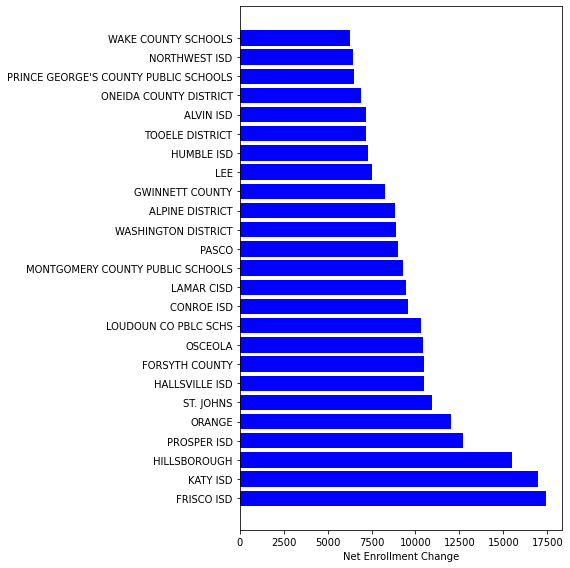

In [76]:
#top 25 districts with net enrollment growth
fig, ax = plt.subplots(figsize=(8, 8))
plt.barh(top25g['Agency Name'], top25g['Net Enrollment Change'], color='blue')
plt.xlabel('Net Enrollment Change')
plt.tight_layout()
plt.show();

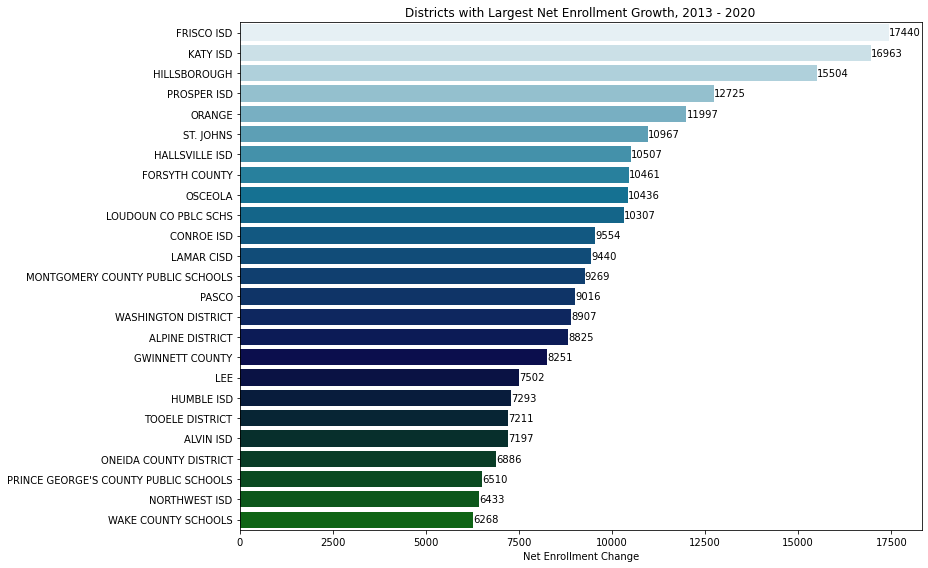

In [77]:
#top 25 districts with net enrollment growth, seaborn
fig, ax = plt.subplots(figsize=(13, 8))
ax = sns.barplot(x='Net Enrollment Change', y='Agency Name',
            data=top25g,
           palette='ocean_r')
ax.bar_label(ax.containers[0])
plt.xlabel('Net Enrollment Change')
plt.ylabel(None)
plt.title('Districts with Largest Net Enrollment Growth, 2013 - 2020')
plt.tight_layout()
plt.show();
#not sure if the bar labels are helpful or distracting at this point

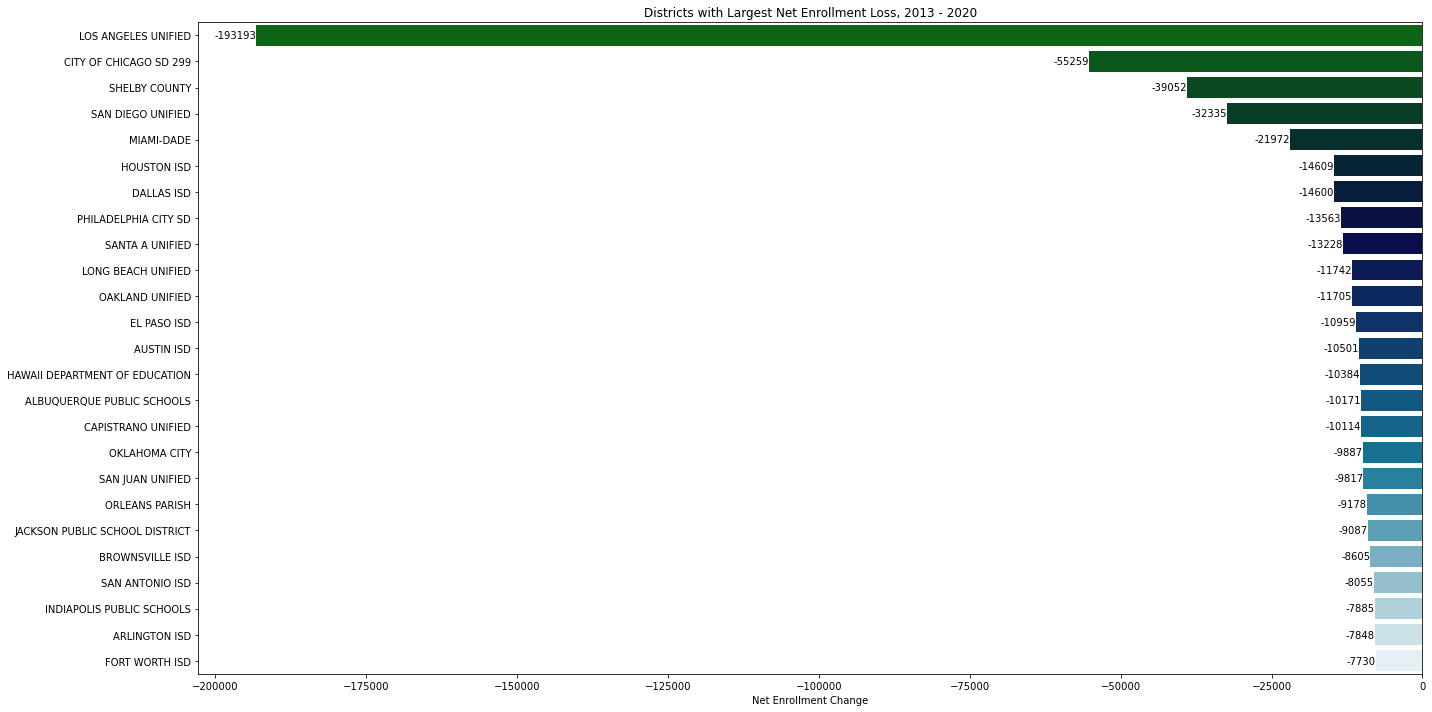

In [80]:
#top 25 districts with net enrollment loss, seaborn
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(x='Net Enrollment Change', y='Agency Name',
            data=top25l,
           palette='ocean')
ax.bar_label(ax.containers[0])
plt.xlabel('Net Enrollment Change')
plt.ylabel(None)
plt.title('Districts with Largest Net Enrollment Loss, 2013 - 2020')
plt.tight_layout()
plt.show();
#look into changing the x axis labels so that the graph doesn't have to stretch as much for LAUSD 

In [81]:
top25combo = pd.concat([top25g, top25l])
top25combo

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Annual Budgetary Change,Net Budgetary Change
91432,FRISCO ISD,TEXAS,TX,4820010.00,COLLIN COUNTY,46053.00,2013.00,NaN,17440.00,55.00,75035.00,1.00,21-Suburb: Large,1-Open,NaN,3052.00,15.00,5410.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,NaN,107430400.00
92583,KATY ISD,TEXAS,TX,4825170.00,FORT BEND COUNTY,67213.00,2013.00,NaN,16963.00,61.00,77494.00,1.00,21-Suburb: Large,1-Open,NaN,4303.00,16.00,8163.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,NaN,104492080.00
16489,HILLSBOROUGH,FLORIDA,FL,1200870.00,HILLSBOROUGH COUNTY,203439.00,2013.00,NaN,15504.00,310.00,33602.00,1.00,21-Suburb: Large,1-Open,NaN,14266.00,14.00,26640.00,South,Republican,Yes,Student-based foundation,Florida Education Finance Program,NaN,Yes,4571.15,Fla. Stat. Ann. § 1011.62 S.B. 2500,Membership average,Fla. Stat. Ann. § 1011.62,NaN,70871109.60
94764,PROSPER ISD,TEXAS,TX,4836000.00,COLLIN COUNTY,6413.00,2013.00,NaN,12725.00,7.00,75078.00,1.00,41-Rural: Fringe,1-Open,NaN,421.00,15.00,743.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,NaN,78386000.00
16641,ORANGE,FLORIDA,FL,1201440.00,ORANGE COUNTY,187092.00,2013.00,NaN,11997.00,249.00,32801.00,1.00,21-Suburb: Large,1-Open,NaN,11760.00,16.00,22944.00,South,Republican,Yes,Student-based foundation,Florida Education Finance Program,NaN,Yes,4571.15,Fla. Stat. Ann. § 1011.62 S.B. 2500,Membership average,Fla. Stat. Ann. § 1011.62,NaN,54840086.55
16721,ST. JOHNS,FLORIDA,FL,1201740.00,ST. JOHNS COUNTY,33583.00,2013.00,NaN,10967.00,48.00,32084.00,1.00,21-Suburb: Large,1-Open,NaN,2420.00,14.00,4454.00,South,Republican,Yes,Student-based foundation,Florida Education Finance Program,NaN,Yes,4571.15,Fla. Stat. Ann. § 1011.62 S.B. 2500,Membership average,Fla. Stat. Ann. § 1011.62,NaN,50131802.05
91912,HALLSVILLE ISD,TEXAS,TX,4822170.00,HARRISON COUNTY,4760.00,2013.00,NaN,10507.00,7.00,75650.00,1.00,31-Town: Fringe,1-Open,NaN,338.00,14.00,624.00,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,6160.00,Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,NaN,64723120.00
17361,FORSYTH COUNTY,GEORGIA,GA,1302220.00,FORSYTH COUNTY,40691.00,2013.00,NaN,10461.00,36.00,30040.00,1.00,21-Suburb: Large,1-Open,NaN,2375.00,17.00,4296.00,South,Democrat,Yes,Hybrid,Quality Basic Education,NaN,Yes,2775.21,HB793 (Budget bill),Multiple counts,Ga. Code Ann. § 20-2-160,NaN,29031471.81
16649,OSCEOLA,FLORIDA,FL,1201470.00,OSCEOLA COUNTY,58204.00,2013.00,NaN,10436.00,69.00,34744.00,1.00,21-Suburb: Large,1-Open,NaN,3517.00,17.00,7093.00,South,Republican,Yes,Student-based foundation,Florida Education Finance Program,NaN,Yes,4571.15,Fla. Stat. Ann. § 1011.62 S.B. 2500,Membership average,Fla. Stat. Ann. § 1011.62,NaN,47704521.40
97823,LOUDOUN CO PBLC SCHS,VIRGINIA,VA,5102250.00,LOUDOUN COUNTY,70759.00,2013.00,NaN,10307.00,85.00,20148.00,1.00,21-Suburb: Large,1-Open,NaN,5026.00,14.00,10784.00,South,Democrat,No,Resource-based allocation,Standards of Quality Formula,NaN,No,NaN,NaN,Membership average,Va. Code Ann. § 22.1-70.1 Va. Code Ann. § 22.1...,NaN,NaN


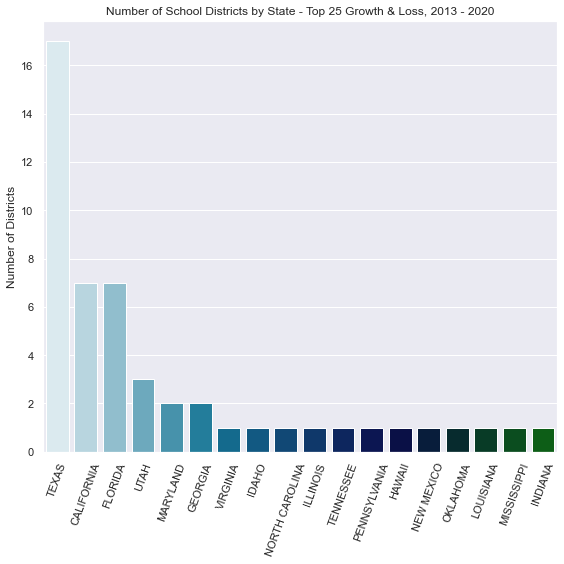

In [82]:
#profiles of top 25 - state
sns.set(rc={"figure.figsize":(8,8)})
state_order=['TEXAS', 'CALIFORNIA', 'FLORIDA', 'UTAH', 'MARYLAND', 'GEORGIA', 'VIRGINIA', 'IDAHO', 'NORTH CAROLINA', 'ILLINOIS', 'TENNESSEE', 'PENNSYLVANIA', 'HAWAII', 'NEW MEXICO', 'OKLAHOMA', 'LOUISIANA', 'MISSISSIPPI', 'INDIANA']
sns.countplot(x='State Name', data=top25combo, order=state_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by State - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

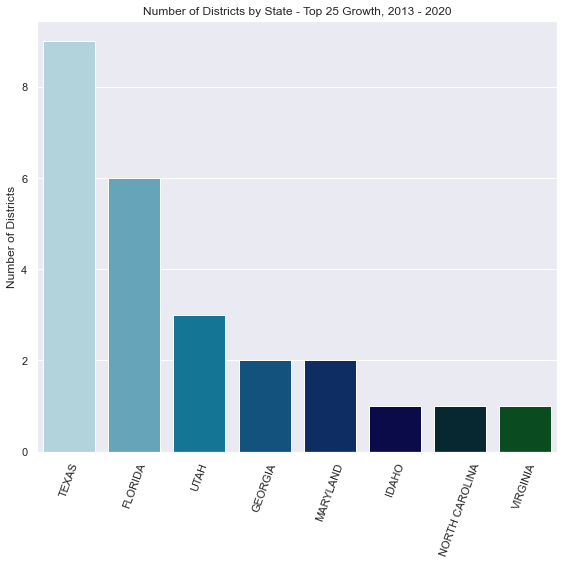

In [83]:
#countplot by state for top 25 enrollment growth
sns.set(rc={"figure.figsize":(8,8)})
state_order=['TEXAS', 'FLORIDA', 'UTAH', 'GEORGIA', 'MARYLAND', 'IDAHO', 'NORTH CAROLINA', 'VIRGINIA']
sns.countplot(x='State Name', data=top25g, order=state_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of Districts by State - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

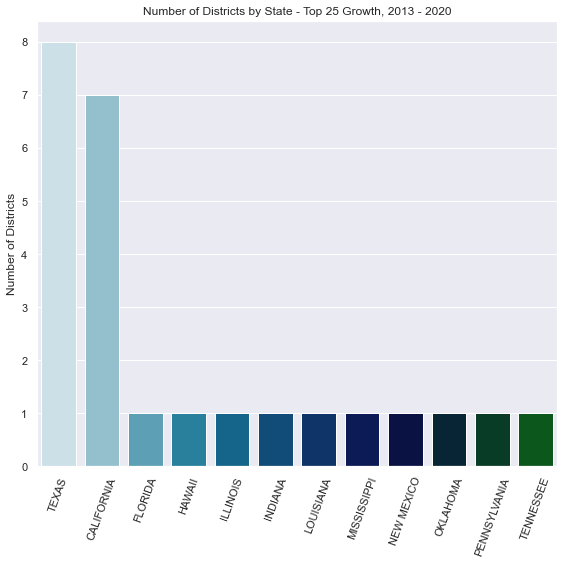

In [84]:
#countplot by state for top 25 enrollment loss
sns.set(rc={"figure.figsize":(8,8)})
state_order=['TEXAS', 'CALIFORNIA', 'FLORIDA', 'HAWAII', 'ILLINOIS', 'INDIANA', 'LOUISIANA', 'MISSISSIPPI', 'NEW MEXICO', 'OKLAHOMA', 'PENNSYLVANIA', 'TENNESSEE']
sns.countplot(x='State Name', data=top25l, order=state_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of Districts by State - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

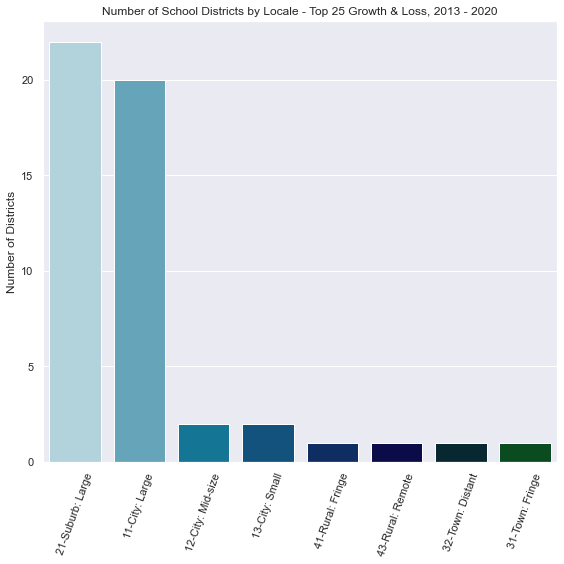

In [85]:
#profiles of top 25 - locale
sns.set(rc={"figure.figsize":(8,8)})
locale_order=['21-Suburb: Large', '11-City: Large', '12-City: Mid-size', '13-City: Small', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='Locale', data=top25combo, order=locale_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Locale - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

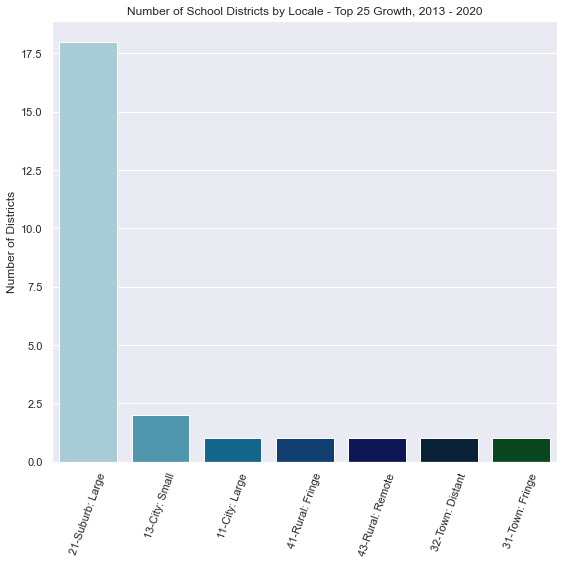

In [86]:
#profiles of top 25 growth - locale
sns.set(rc={"figure.figsize":(8,8)})
locale_order=['21-Suburb: Large', '13-City: Small', '11-City: Large', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='Locale', data=top25g, order=locale_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Locale - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

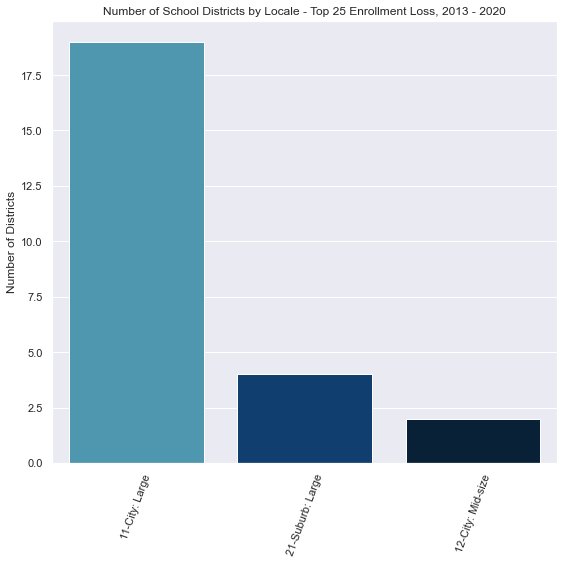

In [87]:
#profiles of top 25 loss - locale
sns.set(rc={"figure.figsize":(8,8)})
#locale_order=['21-Suburb: Large', '13-City: Small', '11-City: Large', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='Locale', data=top25l, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Locale - Top 25 Enrollment Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

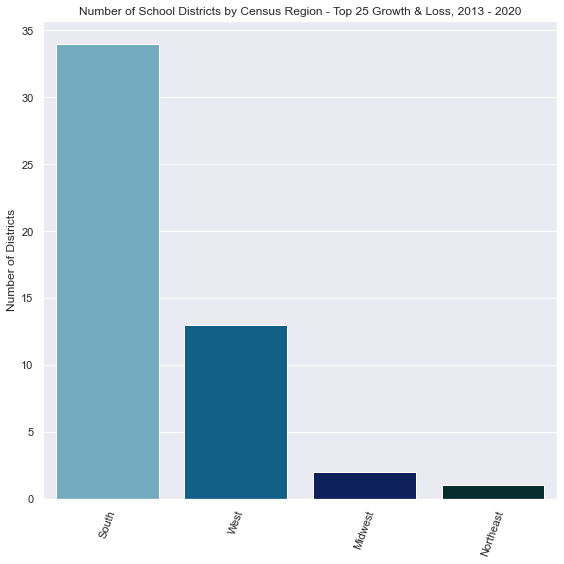

In [88]:
#profiles of top 25 - census region
sns.set(rc={"figure.figsize":(8,8)})
#locale_order=['21-Suburb: Large', '11-City: Large', '12-City: Mid-size', '13-City: Small', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='Census Region', data=top25combo, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Census Region - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

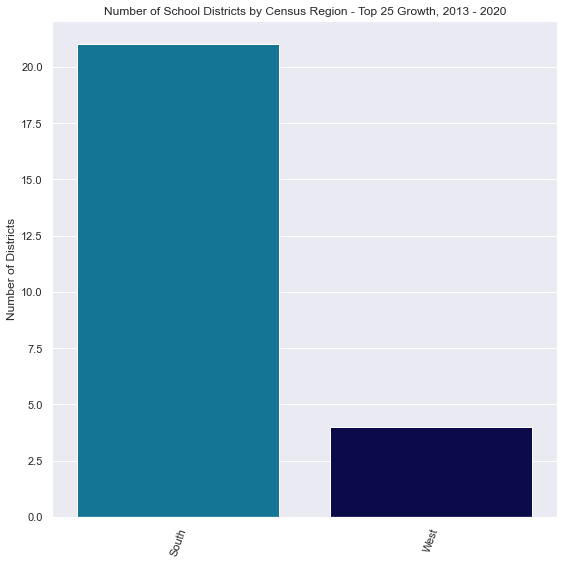

In [89]:
#profiles of top 25 growth - census
sns.set(rc={"figure.figsize":(8,8)})
#locale_order=['21-Suburb: Large', '13-City: Small', '11-City: Large', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='Census Region', data=top25g, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Census Region - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

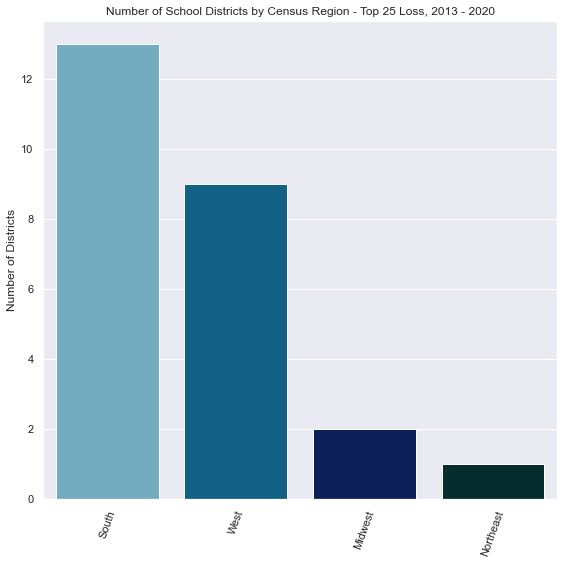

In [90]:
#profiles of top 25 growth - census
sns.set(rc={"figure.figsize":(8,8)})
census_order=['South', 'West', 'Midwest', 'Northeast']
sns.countplot(x='Census Region', data=top25l, order=census_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Census Region - Top 25 Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

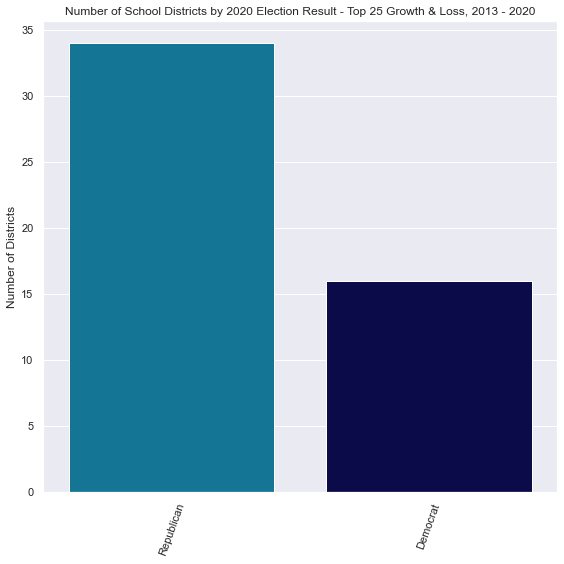

In [91]:
#profiles of top 25 - election result
sns.set(rc={"figure.figsize":(8,8)})
#locale_order=['21-Suburb: Large', '11-City: Large', '12-City: Mid-size', '13-City: Small', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='2020 Election Result', data=top25combo, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by 2020 Election Result - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

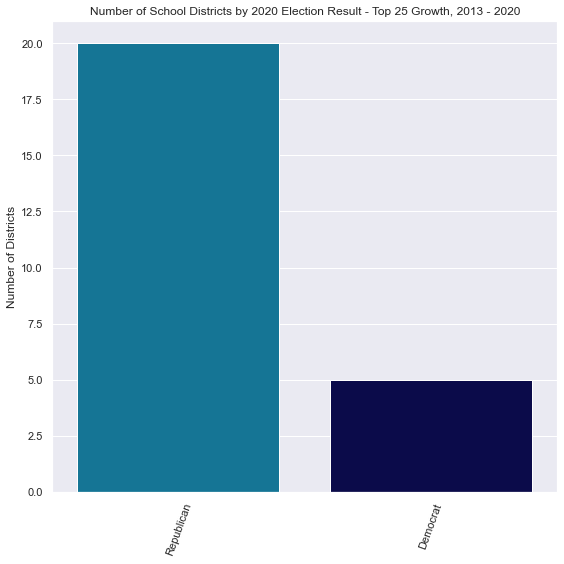

In [92]:
#profiles of top 25 growth - election result
sns.set(rc={"figure.figsize":(8,8)})
#locale_order=['21-Suburb: Large', '13-City: Small', '11-City: Large', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='2020 Election Result', data=top25g, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by 2020 Election Result - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

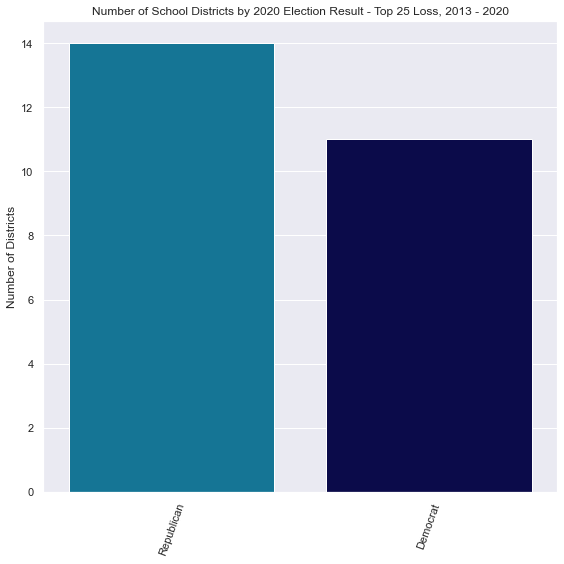

In [93]:
#profiles of top 25 growth - election result
sns.set(rc={"figure.figsize":(8,8)})
result_order=['Republican', 'Democrat']
sns.countplot(x='2020 Election Result', data=top25l, order=result_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by 2020 Election Result - Top 25 Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

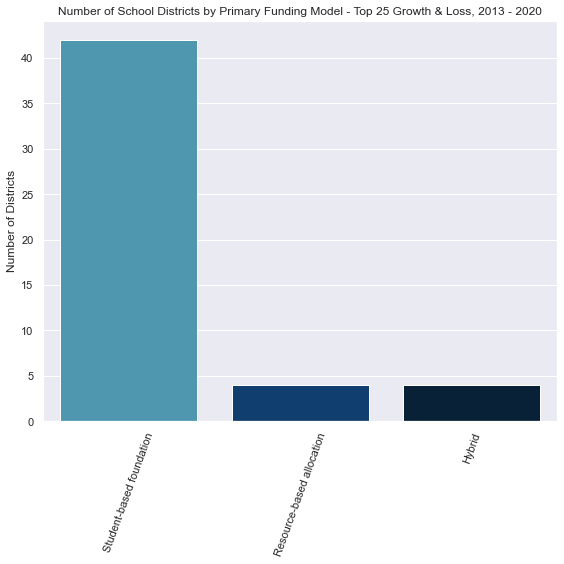

In [94]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Primary Funding Model', data=top25combo, order=funding_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Primary Funding Model - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

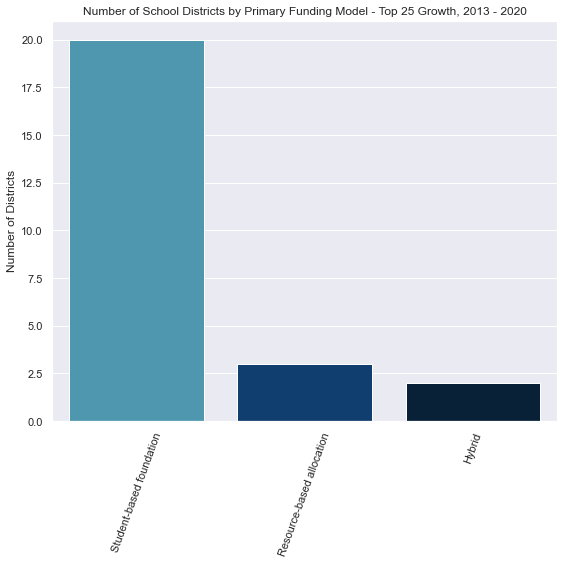

In [95]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Primary Funding Model', data=top25g, order=funding_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Primary Funding Model - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

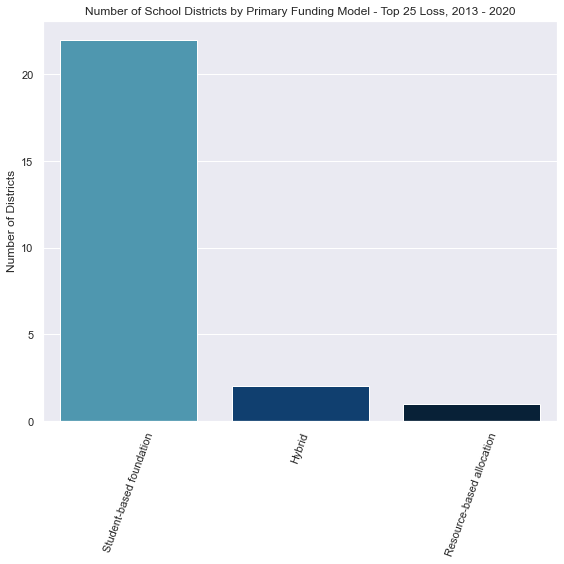

In [96]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Primary Funding Model', data=top25l, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Primary Funding Model - Top 25 Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

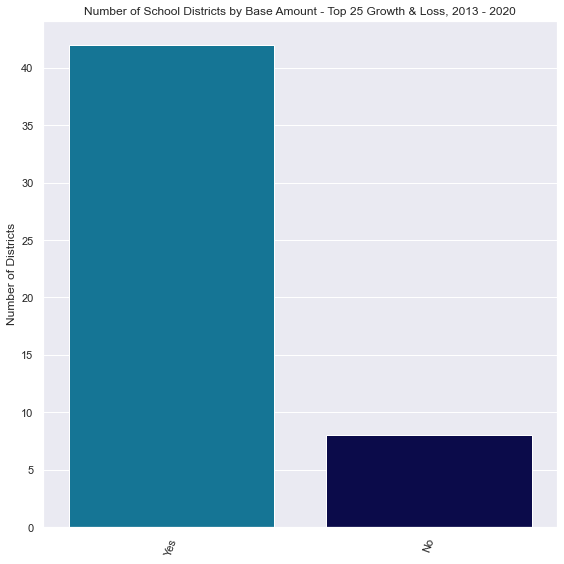

In [97]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Base Amount (Y/N)', data=top25combo, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Base Amount - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

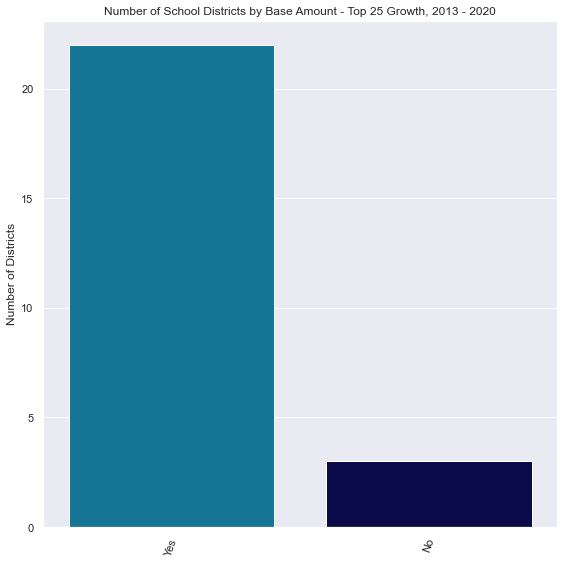

In [98]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Base Amount (Y/N)', data=top25g, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Base Amount - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

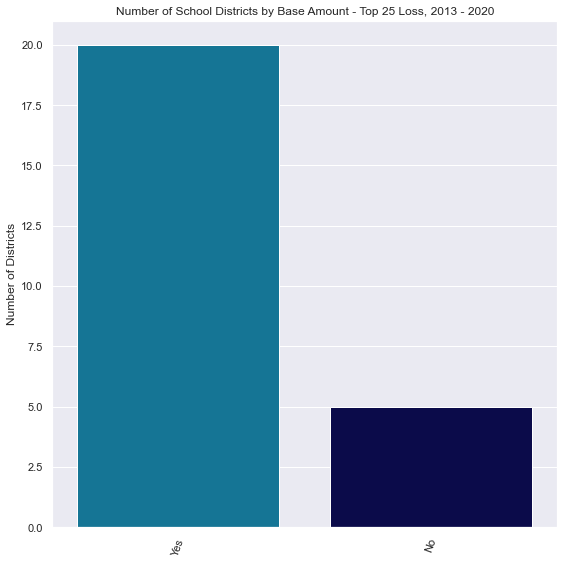

In [99]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Base Amount (Y/N)', data=top25l, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Base Amount - Top 25 Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

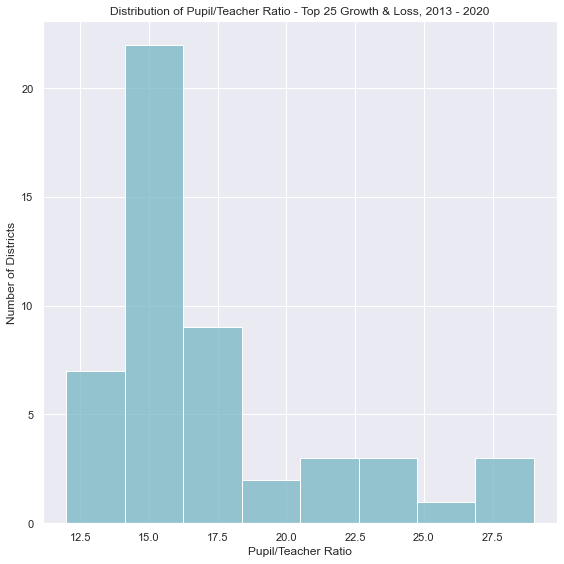

In [100]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.histplot(x='Pupil/Teacher Ratio', data=top25combo, bins=8, color='#76b6c4')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
#plt.xticks(rotation=70)
plt.xlabel('Pupil/Teacher Ratio')
plt.ylabel('Number of Districts')
plt.title('Distribution of Pupil/Teacher Ratio - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

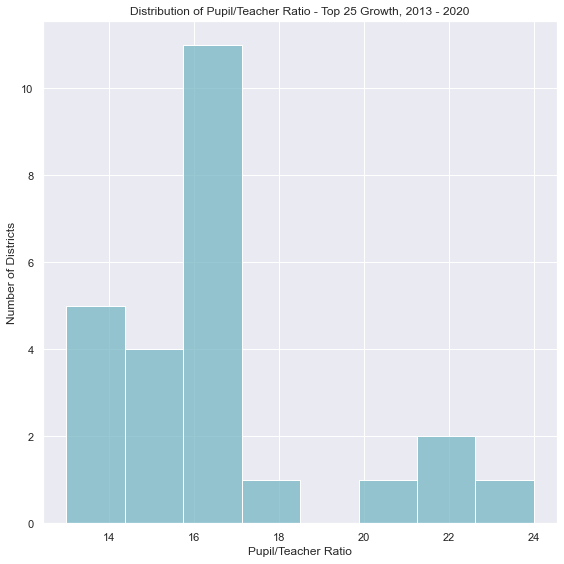

In [101]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.histplot(x='Pupil/Teacher Ratio', data=top25g, bins=8, color='#76b6c4')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
#plt.xticks(rotation=70)
plt.xlabel('Pupil/Teacher Ratio')
plt.ylabel('Number of Districts')
plt.title('Distribution of Pupil/Teacher Ratio - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

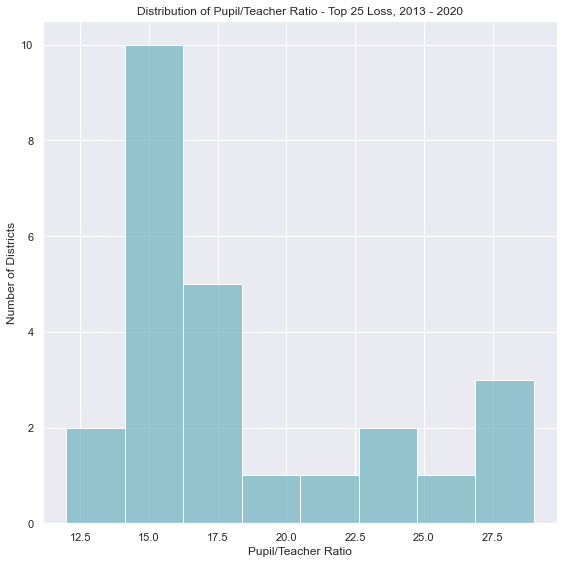

In [102]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.histplot(x='Pupil/Teacher Ratio', data=top25l, bins=8, color='#76b6c4')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
#plt.xticks(rotation=70)
plt.xlabel('Pupil/Teacher Ratio')
plt.ylabel('Number of Districts')
plt.title('Distribution of Pupil/Teacher Ratio - Top 25 Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

C:\Users\cbrown\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


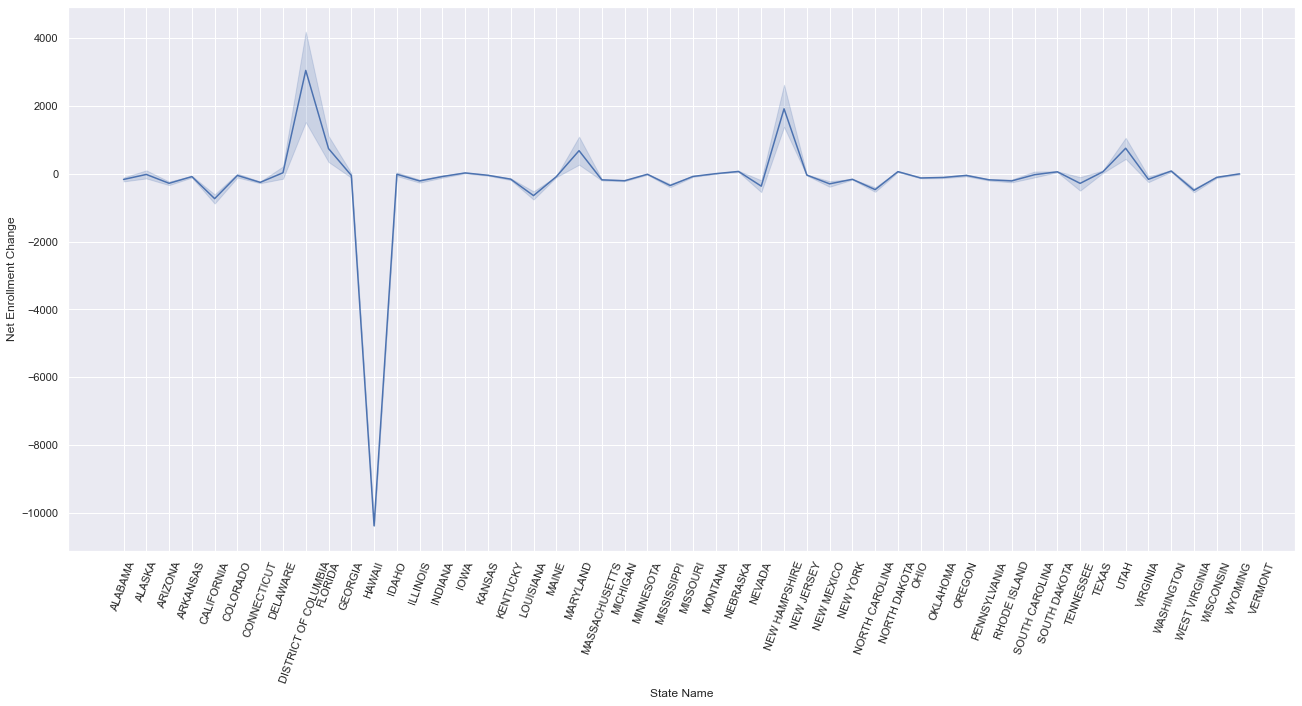

In [106]:
sns.set(rc={"figure.figsize":(22,10)})
sns.lineplot(data['State Name'], data['Net Enrollment Change'])
plt.xticks(rotation=70);

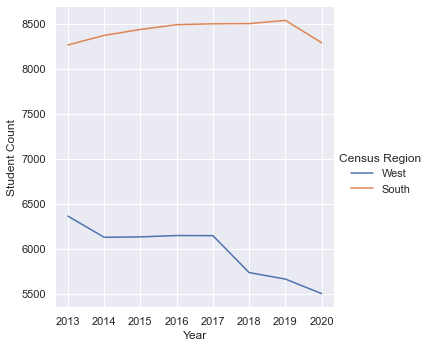

In [104]:
sns.relplot(x='Year', y='Student Count',
           hue='Census Region',
            data=data.loc[data['State Name'].isin(['TEXAS', 'CALIFORNIA', 'FLORIDA', 'UTAH', 'MARYLAND', 'GEORGIA', 'VIRIGINIA', 'IDAHO', 'NORTH CAROLINA'])],
            kind='line', ci=None);

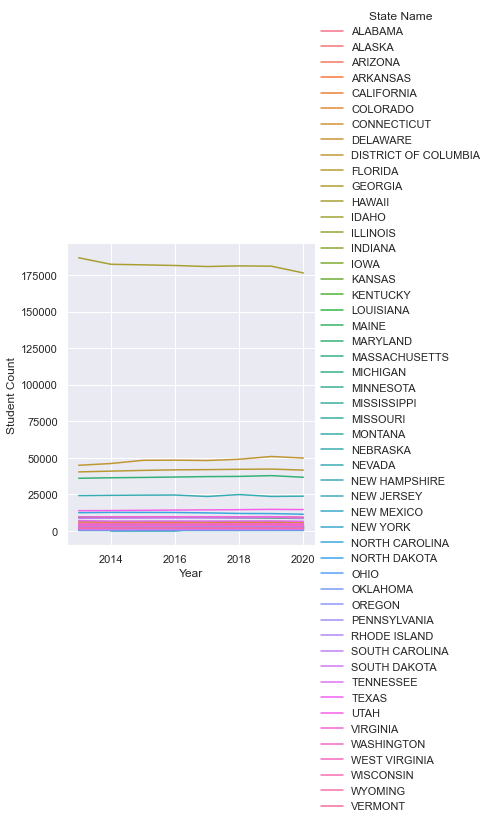

In [108]:
sns.relplot(x='Year', y='Student Count',
           hue='State Name',
            data=data,
            kind='line', ci=None);

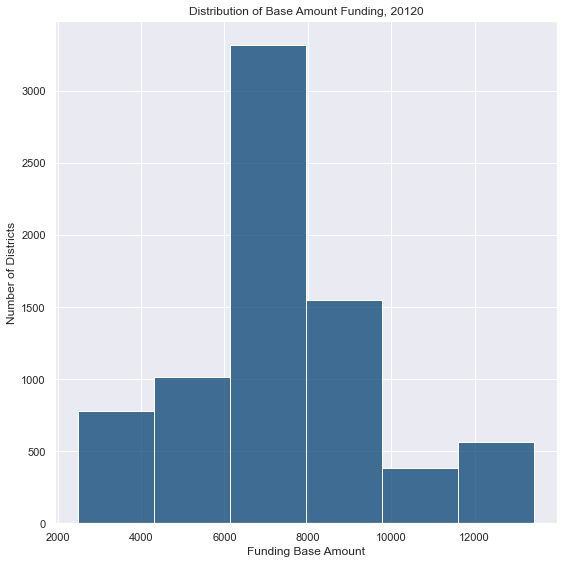

In [126]:
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.histplot(x='Base Amount', data=year20, bins=6, color='#064273')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
#plt.xticks(rotation=70)
plt.xlabel('Funding Base Amount')
plt.ylabel('Number of Districts')
plt.title('Distribution of Base Amount Funding, 20120')
plt.tight_layout()
plt.show();

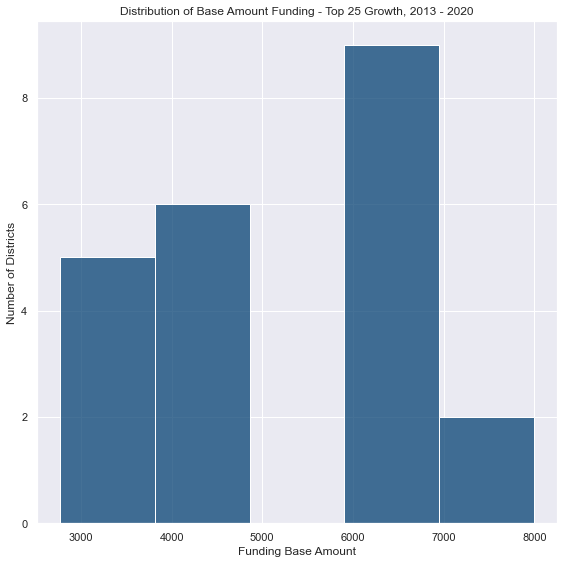

In [113]:
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.histplot(x='Base Amount', data=top25g, bins=5, color='#064273')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
#plt.xticks(rotation=70)
plt.xlabel('Funding Base Amount')
plt.ylabel('Number of Districts')
plt.title('Distribution of Base Amount Funding - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

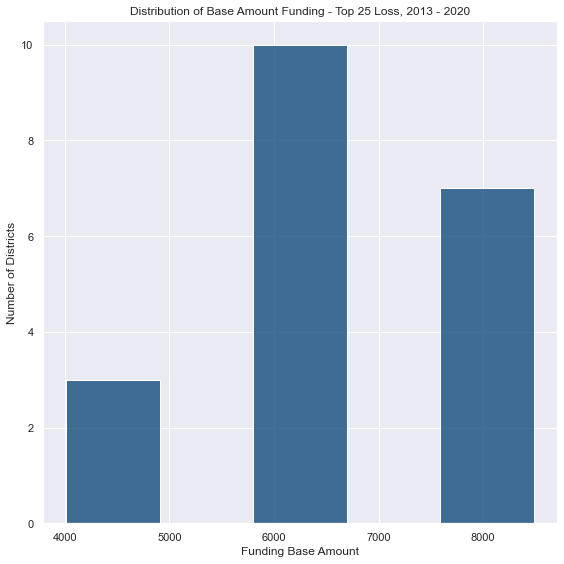

In [114]:
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.histplot(x='Base Amount', data=top25l, bins=5, color='#064273')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
#plt.xticks(rotation=70)
plt.xlabel('Funding Base Amount')
plt.ylabel('Number of Districts')
plt.title('Distribution of Base Amount Funding - Top 25 Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

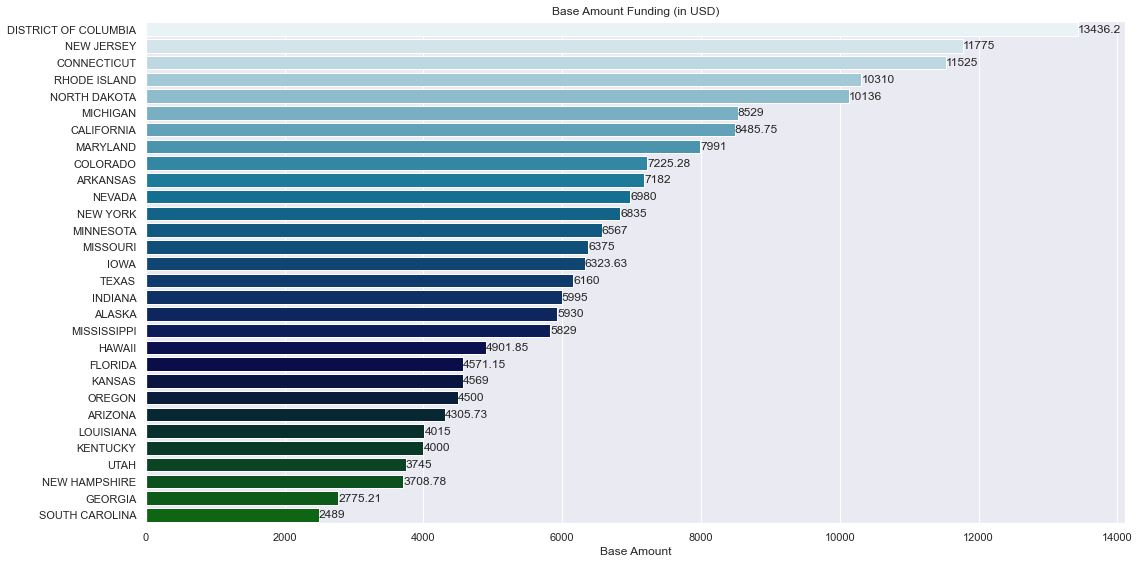

In [123]:
fig, ax = plt.subplots(figsize=(16, 8))
state_order=['DISTRICT OF COLUMBIA', 'NEW JERSEY', 'CONNECTICUT', 'RHODE ISLAND', 'NORTH DAKOTA', 'MICHIGAN', 'CALIFORNIA', 'MARYLAND', 'COLORADO', 'ARKANSAS', 'NEVADA', 'NEW YORK', 'MINNESOTA', 'MISSOURI', 'IOWA', 'TEXAS', 'INDIANA', 'ALASKA', 'MISSISSIPPI', 'HAWAII', 'FLORIDA','KANSAS', 'OREGON', 'ARIZONA', 'LOUISIANA', 'KENTUCKY', 'UTAH', 'NEW HAMPSHIRE', 'GEORGIA', 'SOUTH CAROLINA']
ax = sns.barplot(x='Base Amount', y='State Name',
            data=baseamt,
            order=state_order,
           palette='ocean_r')
ax.bar_label(ax.containers[0])
plt.xlabel('Base Amount')
plt.ylabel(None)
plt.title('Base Amount Funding (in USD)')
plt.tight_layout()
plt.show();

In [120]:
baseamt.groupby('Base Amount')['State Name'].value_counts()

Base Amount  State Name          
2489.00      SOUTH CAROLINA           673
2775.21      GEORGIA                 1440
3708.78      NEW HAMPSHIRE             14
3745.00      UTAH                     328
4000.00      KENTUCKY                1383
4015.00      LOUISIANA                562
4305.73      ARIZONA                 1839
4500.00      OREGON                  1425
4569.00      KANSAS                  2398
4571.15      FLORIDA                  536
4901.85      HAWAII                     8
5829.00      MISSISSIPPI             1162
5930.00      ALASKA                   424
5995.00      INDIANA                 2349
6160.00      TEXAS                   8203
6323.63      IOWA                    2682
6375.00      MISSOURI                4152
6567.00      MINNESOTA               2660
6835.00      NEW YORK                5546
6980.00      NEVADA                   146
7182.00      ARKANSAS                1880
7225.28      COLORADO                1424
7991.00      MARYLAND                 192
